# Importing and Defining Common Functions

## Importing

In [1]:
"""
@author: Tan Nguyen & Matt Bezdek
"""

import pickle as pkl
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.metrics import adjusted_mutual_info_score

import glob
import os
import sys
from joblib import Parallel, delayed
import random
from glob import glob
from copy import deepcopy

from copy import deepcopy
from tqdm import tqdm
from random import shuffle
import traceback

import cv2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
py.offline.init_notebook_mode(connected = True)
import plotly.io as pio
pio.renderers.default = 'jpg'
%cd ../
sys.path.append(os.getcwd())
# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2
from src.utils import get_point_biserial, get_binned_prediction, SegmentationVideo
from src.metric_utils import compute_schema_df_tag, compute_biserial_tag, compute_mi_tag, compute_pc_tag
from typing import List, Dict

/mnt/beegfs/scratch/n.tan/extended-event-modeling


## Global Variables

In [2]:
# global variables
colors = ["lightseagreen", "mediumpurple", "goldenrod", 'yellowgreen', 
          'cornflowerblue', 'darkred', 'bisque', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange',
          'black', 'blanchedalmond',
         'aliceblue', 'antiquewhite', 'aqua', 'aquamarine',
          'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue',
          'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
          'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan',
          'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen',
          'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
          'darkslateblue', 'darkslategray', 'darkslategrey']
valid_runs = ['1.2.3', '2.4.1', '3.1.3', '6.3.9', '1.3.3', '2.2.10', '4.4.3', '6.1.8', '2.2.9', '1.1.6', '3.4.3', '1.3.6', '2.2.1', '6.3.4', '1.2.7', '4.4.2', '6.2.3', '4.3.5', '6.3.8', '2.4.9', '2.4.2', '6.1.5', '1.1.8', '3.1.7']
grain = "fine"

# different SEM models
name_to_tags = dict()

uncertainty_tags = [f'feb_24_uncertainty2.5E-03_s{x}_1E+00_5E-03' for x in range(1010, 1090, 10)]
name_to_tags['uncertainty'] = uncertainty_tags
pe_tags = [f'mar_15_pe4.3E-01_s{x}_2E-02_5E+00' for x in range(1010, 1090, 10)]
name_to_tags['pe'] = pe_tags
full_tags = [
    "april_17_always_s1090_1E-01_5E+05",
    "april_17_always_s1140_1E-01_5E+05",
    "april_17_always_s1120_1E-01_5E+05",
    "april_17_always_s1020_1E-01_5E+05",
    "april_17_always_s1070_1E-01_5E+05",
    "april_17_always_s1030_1E-01_5E+05",
    "april_17_always_s1110_1E-01_5E+05",
    "april_17_always_s1100_1E-01_5E+05"
]
name_to_tags['full'] = full_tags
uncertainty_match_pe_tags = [f'feb_27_uncertainty2.5E-03_s{x}_2E-02_1E-01' for x in range(1010, 1090, 10)]
name_to_tags['uncertainty_match_pe'] = uncertainty_match_pe_tags
pe_match_uncertainty_tags = [f'feb_28_pe5.0E-01_s{x}_1E+00_5E-03' for x in range(1010, 1090, 10)]
name_to_tags['pe_match_uncertainty'] = pe_match_uncertainty_tags
## notes that full_noskel and full_nosema has eval every 20 epochs, not 10.
full_noskel_tags = [f"april_21_noskel_s{x}_1E-01_5E+05" for x in 
                    ['1020', '1140', '1110', '1120', '1010', '1070', '1270', '1060',
                     '1030', '1130', '1080', '1050', '1210', '1250', '1100']
]
name_to_tags['full_noskel'] = full_noskel_tags
full_nosema_tags = [f"april_24_nosema_s{x}_1E-01_5E+05" for x in 
                    ['1270', '1020', '1040', '1210', '1250', '1030', '1150', '1070', 
                     '1100', '1130', '1080', '1140', '1060', '1110', '1300', '1230', '1050']
]
name_to_tags['full_nosema'] = full_nosema_tags

uncertainty_noskel_tags = [f"july_30_uncertainty_noskel_2.5E-03_s{x}_1E+00_5E-03" for x in range(1010, 1110, 10)]
name_to_tags['uncertainty_noskel'] = uncertainty_noskel_tags
pe_noskel_tags = [f"july_30_pe_noskel_4.3E-01_s{x}_2E-02_5E+00" for x in range(1010, 1110, 10)]
name_to_tags['pe_noskel'] = pe_noskel_tags

# human segmentation and categorization data
annotdf = pd.read_csv('./resources/event_annotation_timing_average.csv')
seg_data = pd.read_csv('./resources/seg_data_analysis_clean.csv')

# sample data for experiments
default_tag = "feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03"
sample_readout_dataframes = pkl.load(open(f'output/run_sem/{default_tag}/1.2.3_kinect_trim{default_tag}_diagnostic_21.pkl', 'rb'))

In [3]:
name_to_tags.keys()

dict_keys(['uncertainty', 'pe', 'full', 'uncertainty_match_pe', 'pe_match_uncertainty', 'full_noskel', 'full_nosema', 'uncertainty_noskel', 'pe_noskel'])

In [ ]:
sample_readout_dataframes

In [5]:
run_to_duration = pd.read_csv("./resources/run_specs.csv")
lengths = run_to_duration.total_seconds.to_numpy()
sim = 15
epoch_to_duration = dict()
for i in range(1, 112, 1):
    epoch_to_duration[i] = np.average([np.sum(np.random.choice(lengths, i, replace=False)) 
                                       for _ in range(sim)])
epoch_to_duration[0] = 0

In [6]:
run_to_duration.head(5)

,run,width,height,fps,total_frames,total_seconds
0,6.2.4_kinect_trim,960.0,540.0,25.0,13662.0,546.48
1,6.3.8_kinect_trim,960.0,540.0,25.0,15485.0,619.40
2,2.2.6_kinect_trim,960.0,540.0,25.0,13041.0,521.64
3,2.4.9_kinect_trim,960.0,540.0,25.0,14168.0,566.72
4,1.2.4_kinect_trim,960.0,540.0,25.0,14540.0,581.60


In [7]:
float(run_to_duration[run_to_duration.run == '2.4.4' + "_kinect_trim"]['fps'])

25.0

## Plotly General Configs

In [8]:
import plotly.io as pio
pio.templates.default = "simple_white"

layout = dict(showlegend=True, margin=dict(autoexpand=True), title_font=dict(size=22), title_x=0.5)
x_axis = dict(title=dict(font=dict(size=30)), tickfont=dict(size=18))
y_axis = dict(title=dict(font=dict(size=30)), tickfont=dict(size=18))

# Prepare Master Dataframe

In [ ]:
# this schema_df is only used to extract PE, other dfs don't derive from this schema_df but the cached schema_df
schema_df = pd.DataFrame()
for key in name_to_tags.keys():
    print(f'Preparing schema_df for {key}')
    # if the kernel keeps dying with parallel, turn to serial in this and also within compute_schema_df_tag
    tag_schema_dfs = []
    for tag in name_to_tags[key]:
        tag_schema_dfs.append(compute_schema_df_tag(tag))
#     tag_schema_dfs = Parallel(n_jobs=4)(delayed(compute_schema_df_tag)(tag) for tag in name_to_tags[key])
    schema_df = pd.concat([schema_df, pd.concat(tag_schema_dfs)])


In [10]:
schema_df.head(5)

,run,epoch,e_hat,sec,pe,pe_w,pe_w2,pe_w3,tag,gt_freqs,...,eb_pe_w3_rs,eb_pe,eb_pe_w,eb_pe_w2,eb_pe_w3,ev,event_boundary,movie_boundary,event_boundary_rs,ev_fact
0,2.2.8,71,20,6.240000,0.000000,0.000000,0.0,0.0,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,0.091006,...,1,0,0,1,1,none,0,0,False,0
1,2.2.8,71,20,6.499222,0.601724,0.804133,0.0,0.0,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,0.090982,...,1,0,0,1,1,none,0,0,False,0
2,2.2.8,71,20,6.820667,0.464971,0.684614,0.0,0.0,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,0.090957,...,1,0,0,1,1,none,0,0,False,0
3,2.2.8,71,20,7.159900,0.586079,0.690661,0.0,0.0,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,0.087356,...,1,0,0,1,1,none,0,0,False,0
4,2.2.8,71,20,7.499111,0.801870,0.871499,0.0,0.0,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,0.082344,...,1,0,0,1,1,none,0,0,False,0


# Segmentation

## Segmentation Grain

In [13]:
grain = 'fine'
# get human segmentation with the same second_interval
def pool_boundaries(run):
    video_path = run + "_kinect_trim.mp4"
    seg_video = SegmentationVideo(data_frame=seg_data, video_path=video_path)
    segments = seg_video.get_human_segments(n_annotators=100, condition=grain, second_interval=1)
    return segments

In [14]:
segments = Parallel(n_jobs=12)(delayed(pool_boundaries)(run) for run in valid_runs)

In [15]:
counts = []
distances = []
for x in segments:
    for boundaries in x:
        counts.append(len(boundaries))
        distances.extend(boundaries[1:] - boundaries[:-1])

In [16]:
boundaries

array([ 18.695996,  25.167189,  27.78789 ,  34.064531,  58.775344,
        59.834112,  66.386182,  67.49694 ,  71.620473,  81.346602,
        85.476447,  96.558319,  98.016767, 101.447426, 104.499676,
       107.295452, 136.510849, 141.408257, 148.437591, 155.877449,
       159.518943, 161.384539, 163.973725, 167.643441, 170.36912 ,
       183.934752, 188.714627, 192.5534  , 194.554309, 198.078005,
       200.846194, 203.245811, 207.786369, 210.803531, 213.205913,
       215.378967, 217.686166, 220.733201, 225.673006, 232.823657,
       235.32053 , 237.740307, 249.72319 , 275.303725, 284.522581,
       303.261515, 352.328441, 360.477789, 373.243493, 375.474406,
       384.309156, 386.207949, 389.098379, 396.90478 , 399.844975,
       400.579639, 402.580329, 404.47893 , 408.002953, 409.660938,
       411.707309, 448.305663, 450.465453, 453.549447, 464.960911,
       467.733307, 470.49731 , 475.00019 , 482.595205, 487.093564,
       492.582383, 493.852915, 495.30382 , 496.22141 , 507.951

In [17]:
np.mean(counts), np.median(counts)

(28.089473684210525, 23.0)

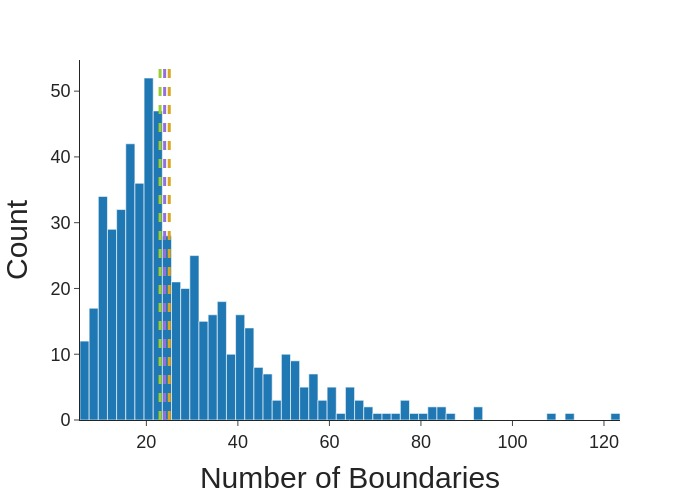

In [18]:
fig = px.histogram(counts, nbins=100)
fig.update_layout(layout)
fig.update_layout(#title_text=f"Human's Number of Boundaries (Fine-grain)", 
                  showlegend=False)
fig.update_xaxes(x_axis)
fig.update_xaxes(title_text="Number of Boundaries")
fig.update_yaxes(y_axis)
fig.update_yaxes(title_text="Count")
fig.add_vline(x=24, line_width=3, line_dash="dash", line_color=colors[1], opacity=1)
fig.add_vline(x=25, line_width=3, line_dash="dash", line_color=colors[2], opacity=1)
fig.add_vline(x=23, line_width=3, line_dash="dash", line_color=colors[3], opacity=1)
# fig.add_annotation(dict(font=dict(color='black',size=15),
#                                         x=.16,
#                                         y=.85,
#                                         showarrow=False,
#                                         text="SEM's average adjusted number of boundaries",
#                                         textangle=0,
#                                         xanchor='left',
#                                         xref="paper",
#                                         yref="paper"))
fig.show()

## Boundary to Boundary Lags (event lengths)

In [19]:
boundary_df = schema_df.loc[:, ['run', 'epoch', 'tag', 'event_boundary','event_boundary_rs', 
#                         'eb_pe', 'eb_pe_w', 'eb_pe_w2', 'eb_pe_w3'
                               ]]
boundary_df = boundary_df[boundary_df.tag.isin(full_tags + pe_tags + uncertainty_tags)]
boundary_df.head(5)

,run,epoch,tag,event_boundary,event_boundary_rs
0,2.2.8,71,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,0,False
1,2.2.8,71,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,0,False
2,2.2.8,71,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,0,False
3,2.2.8,71,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,0,False
4,2.2.8,71,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,0,False


In [20]:
def compute_elapse(run, epoch, boundary_df):
    for tag in boundary_df.tag.unique():
        df_select = boundary_df[(boundary_df.run == run) & (boundary_df.epoch == epoch) & (boundary_df.tag == tag)]
        if len(df_select):
            b_indices = np.where((df_select.event_boundary_rs == 1).to_numpy() == 1)[0]
            elapses = b_indices[1:] - b_indices[:-1]
            df_elapse = pd.DataFrame({'tag': tag, 'epoch': epoch, 'run': run, 'elapse': elapses})
            return df_elapse

def compute_elapse_end(run, boundary_df_tag):
    df_select = boundary_df_tag[(boundary_df_tag.run == run) & (boundary_df_tag.epoch == 91)]
    if len(df_select):
        b_indices = np.where((df_select.event_boundary_rs == 1).to_numpy() == 1)[0]
        elapses = b_indices[1:] - b_indices[:-1]
        df_elapse = pd.DataFrame({'tag': tag, 'epoch': 101, 'run': run, 'elapse': elapses})
        return df_elapse

In [21]:
df_elapse = pd.DataFrame(columns=['tag', 'epoch', 'run','elapse'])
for tag in tqdm(boundary_df.tag.unique()):
    boundary_df_tag = boundary_df[(boundary_df.tag == tag) & (boundary_df.run.isin(valid_runs))]
    elapses = Parallel(n_jobs=12)(delayed(compute_elapse_end)(run, boundary_df_tag) 
                                 for run in boundary_df_tag.run.unique())
    df_elapse = pd.concat(elapses + [df_elapse])

df_elapse.head(5)

100%|██████████| 24/24 [00:43<00:00,  1.83s/it]


,tag,epoch,run,elapse
0,feb_26_always_s1080_1E-01_5E+05,101,2.4.2,4
1,feb_26_always_s1080_1E-01_5E+05,101,2.4.2,2
2,feb_26_always_s1080_1E-01_5E+05,101,2.4.2,5
3,feb_26_always_s1080_1E-01_5E+05,101,2.4.2,5
4,feb_26_always_s1080_1E-01_5E+05,101,2.4.2,1


In [22]:
df_elapse['config'] = df_elapse.tag.apply(lambda x: 'pe' if x in pe_tags else ('uncertainty' if x in uncertainty_tags else 'full'))
df_elapse.config.unique()

array(['full', 'pe', 'uncertainty'], dtype=object)

In [23]:
df_elapse['elapse_s'] = df_elapse.elapse / 3
df_elapse.loc[df_elapse['elapse_s'] > 30, 'elapse_s'] = 0
df_elapse.loc[df_elapse['elapse'] >= 90, 'elapse'] = 0

In [24]:
df_elapse.head(5)

,tag,epoch,run,elapse,config,elapse_s
0,feb_26_always_s1080_1E-01_5E+05,101,2.4.2,4,full,1.333333
1,feb_26_always_s1080_1E-01_5E+05,101,2.4.2,2,full,0.666667
2,feb_26_always_s1080_1E-01_5E+05,101,2.4.2,5,full,1.666667
3,feb_26_always_s1080_1E-01_5E+05,101,2.4.2,5,full,1.666667
4,feb_26_always_s1080_1E-01_5E+05,101,2.4.2,1,full,0.333333


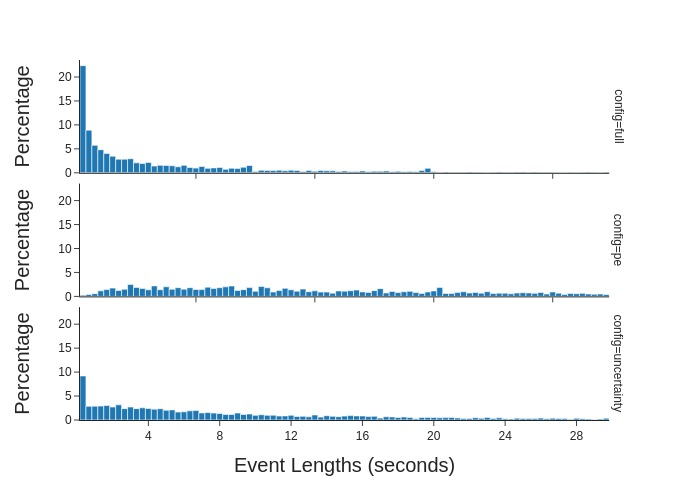

In [25]:
fig = px.histogram(df_elapse[df_elapse.elapse > 0], x='elapse', facet_row='config', histnorm='percent')
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = np.arange(0, 91, 12),
        ticktext = [str(int(x)) for x in (np.arange(0, 91, 12) / 3)]
    )
)
fig.update_xaxes(title=dict(text="Event Lengths (seconds)", font=dict(size=20)), row=1)
fig.update_yaxes(title=dict(text="Percentage", font=dict(size=20)))
fig.write_html('5_event_lengths.html')
fig.show()

## Biserial Correlation

### Prepare Biserial Dataframe

In [ ]:
# do not need to save group here, tag-wise df is saved when computing using compute_biserial_tag
biserial_df = pd.DataFrame()
# for rmf in [True, False]:
rmf = True
for key in name_to_tags.keys():
    tag_biserial_dfs = Parallel(n_jobs=11)(delayed(compute_biserial_tag)(tag=tag, remove_flurry=rmf) for tag in name_to_tags[key])
    biserial_df = pd.concat([biserial_df, pd.concat(tag_biserial_dfs)])
#     biserial_df.to_csv(f'./output/dataframes/group_biserial_df_{key}_rmf{rmf}.csv', index=False)

In [27]:
bi_df_long = pd.melt(biserial_df, id_vars = ["epoch", "tag"], 
                            value_vars=['bi', 'bi_shuffle', 
                                        # 'bi_pe', 'bi_pe_w2', 
                                        # 'bi_pe_w3', 'bi_pe_w'
                                        ])
bi_df_long.head(5)

,epoch,tag,variable,value
0,71,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,bi,0.399498
1,71,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,bi,0.399498
2,71,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,bi,0.399498
3,71,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,bi,0.399498
4,71,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,bi,0.399498


In [28]:
# construct a dataframe of human biserial correlation to normative boundary for each run
seg_path = './resources/seg_data_analysis_clean.csv'
data_frame = pd.read_csv(seg_path)
human_seg = pd.DataFrame(columns=["run", "biserials"])
for v in valid_runs:
    video_path = v + '_C1_trim.mp4'
    seg_video = SegmentationVideo(data_frame=data_frame, video_path=video_path)
    seg_points = seg_video.get_human_segments(n_annotators=100, condition='coarse')
    last = round(max(np.concatenate(seg_points))) + 5
    # this function aggregate subject boundaries, apply a gaussian kernel and calculate correlations for subjects
    seg_video.get_gt_freqs(end_second=last)
    biserials = seg_video.get_biserial_subjects(end_second=last)
    human_seg.loc[len(human_seg), :] = [v, biserials]
# human_seg

/home/n.tan/.conda/envs/sem-viz-jupyter/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [29]:
# add human biserial correlation to the biserial dataframe, containing SEM and shuffle results
all_bi = []
for x in human_seg['biserials'].to_list():
    all_bi += x
for e in bi_df_long.epoch.unique():
    for bi in all_bi:
        bi_df_long.loc[len(bi_df_long), :] = [e, 'human', 'human', bi]

In [30]:
bi_df_long['training_time'] = bi_df_long['epoch'].map(epoch_to_duration)
bi_df_long['training_time'] = bi_df_long['training_time'] / 60
bi_df_long = bi_df_long.drop_duplicates()
bi_df_long.head(5)

,epoch,tag,variable,value,training_time
0,71.0,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,bi,0.399498,729.010565
11,1.0,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,bi,0.372624,10.303168
22,101.0,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,bi,0.391623,1041.799201
33,81.0,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,bi,0.395539,823.490616
44,21.0,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,bi,0.351709,217.061773


### Multiple Tags, Each with Multiple Simulations

In [31]:
# bi_df_long = bi_df_long[bi_df_long.variable != "human"]

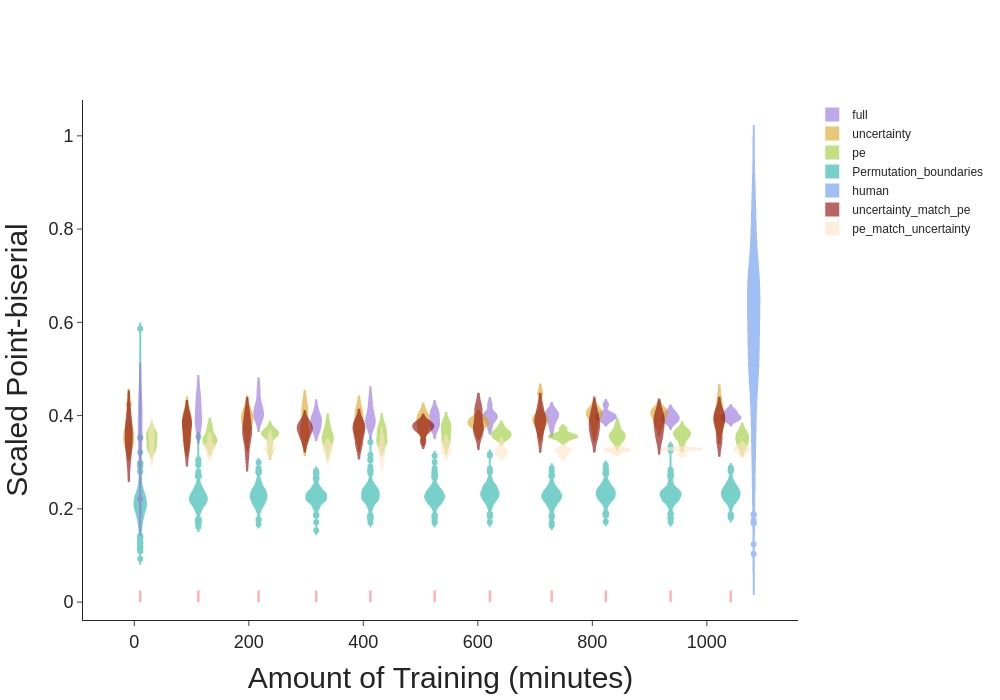

In [34]:
# compare three models with human
fig = go.Figure()

tag_names = ['full', 'uncertainty', 'pe', 'human', 'uncertainty_match_pe', 'pe_match_uncertainty']
# shifts = [0, -20, 20, -20, 20]
shifts = [0, -20, 20, 40, -20, 20, -20, 20]
widths = [35, 35, 50, 20, 35, 70, 35, 35]
point = 0
ranks = [0, 1, 2, 3, 4, 5, 6, 7]

df = bi_df_long[(bi_df_long.variable == 'bi_shuffle')
#                        & (bi_df_long.tag.isin(full_tags))
                      ]
fig.add_trace(
    go.Violin(x=df.training_time, y=df.value, name=f"Permutation_boundaries", fillcolor=colors[0], 
              line_color=colors[0], opacity=0.6, points=point, width=widths[0],
              legendrank=ranks[3])
)

for i, tags in enumerate([full_tags, uncertainty_tags, pe_tags, ['human'], 
                          uncertainty_match_pe_tags, pe_match_uncertainty_tags, 
                          ]):
    df = bi_df_long[(bi_df_long.variable == 'bi') & (bi_df_long.tag.isin(tags))]
    if 'human' in (tags):
        df = bi_df_long[(bi_df_long.epoch > 100) & (bi_df_long.tag.isin(tags))]
#         df = df
    fig.add_trace(
        go.Violin(x=df.training_time+shifts[i], y=df.value, name=f"{tag_names[i]}", 
                  fillcolor=colors[i+1], line_color=colors[i+1], opacity=0.6, 
                  points=point, width=widths[i],
                  scalemode='count',
                  legendrank=ranks[i],
                  # mode='markers', marker=dict(size=5, color=colors[i+1])
                # boxpoints='all'
    ))


fig.update_layout(layout, showlegend=True, width=1000, height=700)
# fig.update_layout(layout)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis)
fig.update_xaxes(title=dict(text="Amount of Training (minutes)"))
fig.update_yaxes(title=dict(text="Scaled Point-biserial"))
# fig.update_layout(width=500)
# fig.update_layout(title="Flurries are removed")
fig.update_layout(shapes=[{'type': 'line','y0':0,'y1': 0.05 * 0.5,
                           'x0': t, 
                           'x1': t,
                           'xref':'x1','yref':'y1',
                           'line': {'color': 'red','width': 2.5}} 
                          for t in bi_df_long.training_time.unique()])
fig.show()

In [56]:
fig.write_html('bi_all_models_human.html')

#### Statistical Tests Biserial

In [35]:
bi_df_long_end = bi_df_long[bi_df_long.training_time > 900]

In [36]:
uncertainty_sample = bi_df_long_end[bi_df_long_end['tag'].isin(uncertainty_tags) & (bi_df_long_end['variable'] == 'bi')]['value'] 
param_match_uncertainty_sample = bi_df_long_end[bi_df_long_end['tag'].isin(uncertainty_match_pe_tags) & (bi_df_long_end['variable'] == 'bi')]['value'] 
full_sample = bi_df_long_end[bi_df_long_end['tag'].isin(full_tags) & (bi_df_long_end['variable'] == 'bi')]['value']
pe_sample = bi_df_long_end[bi_df_long_end['tag'].isin(pe_tags) & (bi_df_long_end['variable'] == 'bi')]['value']
param_match_pe_sample = bi_df_long_end[bi_df_long_end['tag'].isin(pe_match_uncertainty_tags) & (bi_df_long_end['variable'] == 'bi')]['value']
random_sample = bi_df_long_end[(bi_df_long_end['variable'] == 'bi_shuffle')]['value']
human_sample = bi_df_long_end[(bi_df_long_end['variable'] == 'human')]['value']

In [37]:
tstat, pvalue = stats.ttest_ind(uncertainty_sample, full_sample, alternative='two-sided', equal_var=False)
degree_freedom = len(uncertainty_sample) + len(full_sample) - 2
print(f"t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")

t-statistics=0.23, p-value=0.82, df=30


In [38]:
tstat, pvalue = stats.ttest_ind(full_sample, pe_sample, alternative='two-sided', equal_var=False)
degree_freedom = len(pe_sample) + len(full_sample) - 2
print(f"t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")

t-statistics=12.14, p-value=2.8e-12, df=30


In [39]:
tstat, pvalue = stats.ttest_ind(uncertainty_sample, pe_sample, alternative='two-sided', equal_var=False)
degree_freedom = len(uncertainty_sample) + len(pe_sample) - 2
print(f"t-statistics={tstat:.02f}, p-value={pvalue:.02e}, df={degree_freedom}")

t-statistics=8.57, p-value=3.78e-09, df=30


In [40]:
tstat, pvalue = stats.ttest_ind(full_sample, random_sample.dropna().iloc[:48], alternative='two-sided', equal_var=False)
degree_freedom = len(full_sample) + 48 - 2 # (16 + 16*3 - 2)
print(f"t-statistics={tstat:.02f}, p-value={pvalue:.02e}, df={degree_freedom}")

t-statistics=61.59, p-value=2.80e-44, df=62


In [41]:
tstat, pvalue = stats.ttest_ind(uncertainty_sample, random_sample.dropna().iloc[:48], alternative='two-sided', equal_var=False)
degree_freedom = len(uncertainty_sample) + 48 - 2 # (16 + 16*3 - 2)
print(f"t-statistics={tstat:.02f}, p-value={pvalue:.02e}, df={degree_freedom}")

t-statistics=36.81, p-value=6.48e-21, df=62


In [42]:
tstat, pvalue = stats.ttest_ind(pe_sample, random_sample.dropna().iloc[:48], alternative='two-sided', equal_var=False)
degree_freedom = len(pe_sample) + 48 - 2 # (16 + 16*3 - 2)
print(f"t-statistics={tstat:.02f}, p-value={pvalue:.02e}, df={degree_freedom}")

t-statistics=36.10, p-value=1.61e-25, df=62


In [43]:
tstat, pvalue = stats.ttest_ind(param_match_uncertainty_sample, pe_sample, alternative='two-sided', equal_var=False)
degree_freedom = len(param_match_uncertainty_sample) + len(pe_sample) - 2
print(f"two-sided t-test: t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")

two-sided t-test: t-statistics=4.57, p-value=0.00013, df=30


In [44]:
tstat, pvalue = stats.ttest_ind(param_match_pe_sample, uncertainty_sample, alternative='two-sided', equal_var=False)
degree_freedom = len(param_match_uncertainty_sample) + len(pe_sample) - 2
print(f"two-sided t-test: t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")

two-sided t-test: t-statistics=-15.85, p-value=5.2e-12, df=30


In [45]:
stats.percentileofscore(human_sample, np.median(full_sample))

12.006578947368421

In [46]:
stats.percentileofscore(human_sample, np.median(uncertainty_sample))

12.006578947368421

In [47]:
stats.percentileofscore(human_sample, np.median(pe_sample))

8.552631578947368

## Segmentation for Single Activities

In [48]:
df_boundary = deepcopy(schema_df[['run', 'epoch', 'event_boundary', 'gt_freqs', 'tag']])
df_boundary.head(5)

,run,epoch,event_boundary,gt_freqs,tag
0,2.2.8,71,0,0.091006,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03
1,2.2.8,71,0,0.090982,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03
2,2.2.8,71,0,0.090957,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03
3,2.2.8,71,0,0.087356,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03
4,2.2.8,71,0,0.082344,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03


In [49]:
df_boundary_one_run = deepcopy(df_boundary[(df_boundary.epoch == 101) 
                                           & (df_boundary.tag == 'feb_28_pe5.0E-01_s1010_1E+00_5E-03')
                                           & (df_boundary.run == "6.1.8")
                                          ])
# df_boundary_one_run = deepcopy(df_boundary[(df_boundary.run == "6.3.4") & (df_boundary.epoch == "46") & (df_boundary.tag == "june_19_1010_lr1E-03_alfa1E-01_lmda1E+05")])
df_boundary_one_run.head(5)

,run,epoch,event_boundary,gt_freqs,tag
357005,6.1.8,101,0,0.070942,feb_28_pe5.0E-01_s1010_1E+00_5E-03
357006,6.1.8,101,0,0.077183,feb_28_pe5.0E-01_s1010_1E+00_5E-03
357007,6.1.8,101,0,0.083339,feb_28_pe5.0E-01_s1010_1E+00_5E-03
357008,6.1.8,101,0,0.089495,feb_28_pe5.0E-01_s1010_1E+00_5E-03
357009,6.1.8,101,0,0.092532,feb_28_pe5.0E-01_s1010_1E+00_5E-03


In [56]:
def plot_one_run(i, run):
    df_select = df_boundary_one_epoch[df_boundary_one_epoch.run == run].copy()
    # tag here doesn't matter, just to get first_second
    diagnostic_readouts = pkl.load(open(f'output/run_sem/{uncertainty_tags[0]}/{run}_kinect_trim{uncertainty_tags[0]}_diagnostic_101.pkl', 'rb'))
    first_second = diagnostic_readouts['first_frame'] / diagnostic_readouts['fps']
    time = [first_second + 1/3 * x for x in range(len(df_select))]
    df_select['time'] = time
    fig_sub = px.line(df_select, x='time', y="gt_freqs")
    fig.add_trace(
        fig_sub.data[0], col=i%5+1, row=i//5+1
    )

    # for _, row in df_select.iterrows():
    #     if row.event_boundary == 1:
    #         # add_vline update layout, thus cannot use the add_trace trick.
    #         fig.add_vline(x=row.time, line_width=1, line_dash="dash", line_color="green", col=i%4+1, row=i//4+1)
    # use update_layout to add shapes (lines).
    def add_line(row):
        if row.event_boundary == 1:
            return {'type': 'line',
               'line': dict(color="black",width=1,dash="dot",),
               'xref': f'x{i+1}',
               'yref': f'y{i+1}',
               'x0': row.time,
               'y0': 0,
               'x1': row.time,
               'y1': y_max
              }
        return {}
    shapes.extend(Parallel(n_jobs=16)(delayed(add_line)(row) for _, row in df_select.iterrows()))

In [57]:
df_boundary_one_epoch = deepcopy(df_boundary[(df_boundary.epoch == 101) 
                                           & (df_boundary.tag == uncertainty_tags[0])
                                          ])
fig = make_subplots(rows=5, cols=5, shared_yaxes=True, 
                    subplot_titles=valid_runs)
shapes = list()
y_max = df_boundary_one_epoch.gt_freqs.max()
y_max

0.2279639775016865

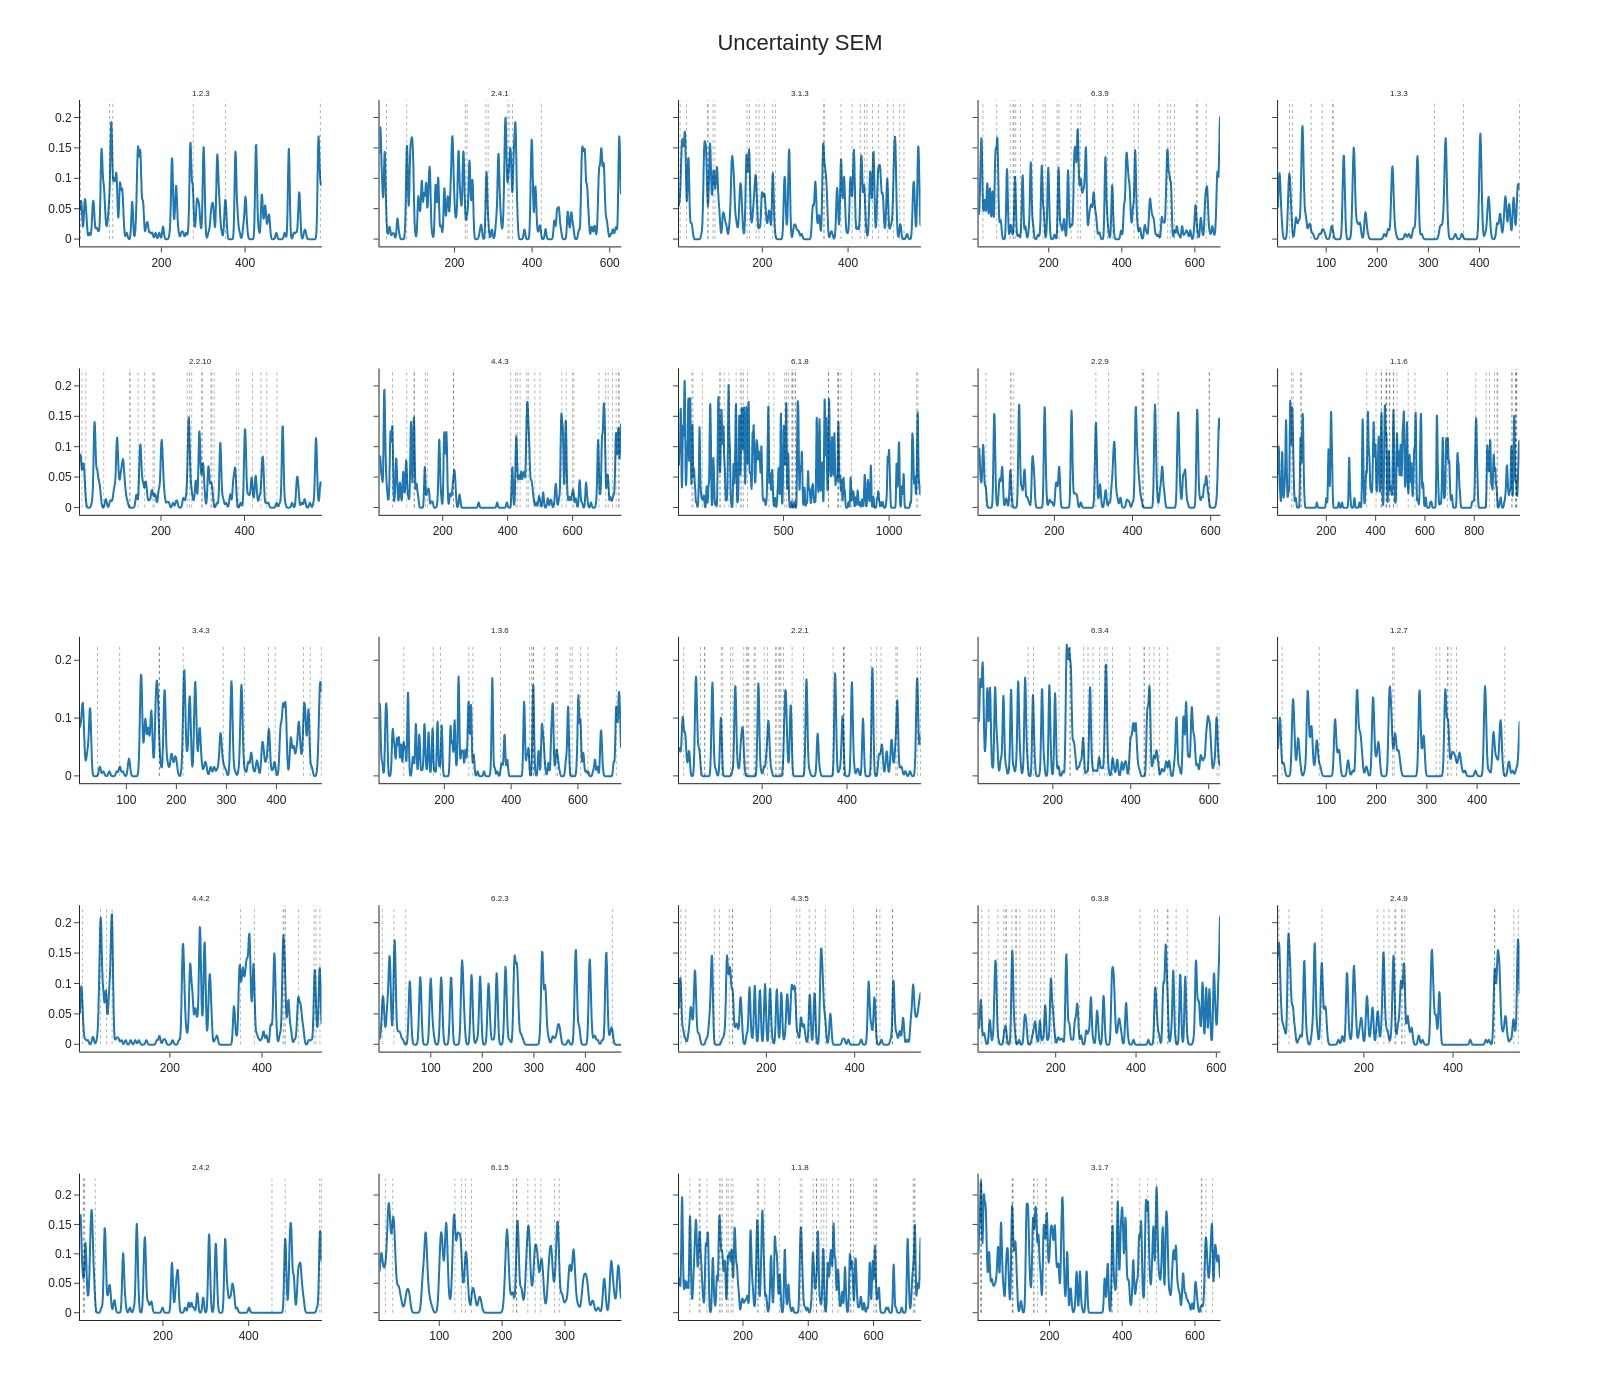

In [58]:
for i, run in zip(range(0, len(valid_runs)), valid_runs):
    plot_one_run(i, run)
shapes = [x for x in shapes if len(x)]
fig.update_layout(layout, shapes=shapes, title_text="Uncertainty SEM")
fig.for_each_annotation(lambda a: a.update(font=dict(size=8)))
fig.update_layout(width=1600, height=1400)
fig.show()

In [108]:
fig.print_grid()

This is the format of your plot grid:
[ (1,1) x,y     ]  [ (1,2) x2,y2   ]  [ (1,3) x3,y3   ]
[ (2,1) x4,y4   ]  [ (2,2) x5,y5   ]  [ (2,3) x6,y6   ]
[ (3,1) x7,y7   ]  [ (3,2) x8,y8   ]  [ (3,3) x9,y9   ]
[ (4,1) x10,y10 ]  [ (4,2) x11,y11 ]  [ (4,3) x12,y12 ]
[ (5,1) x13,y13 ]  [ (5,2) x14,y14 ]  [ (5,3) x15,y15 ]
[ (6,1) x16,y16 ]  [ (6,2) x17,y17 ]  [ (6,3) x18,y18 ]
[ (7,1) x19,y19 ]  [ (7,2) x20,y20 ]  [ (7,3) x21,y21 ]



# Prediction Error


## Prepare PE Dataframe

In [59]:
df_pe = deepcopy(schema_df[['run', 'epoch', 'pe', 'pe_w', 'pe_w2', 'pe_w3', 'tag']])
df_pe = df_pe[df_pe.run.isin(valid_runs)]
df_pe.epoch = df_pe.epoch.astype(int)
df_pe = df_pe.groupby(['epoch', 'run', 'tag']).mean().reset_index(level=['epoch', 'run', 'tag'])
df_pe_long = pd.melt(df_pe, id_vars=["epoch", "run", "tag"], value_vars=['pe', 'pe_w', 'pe_w2', 'pe_w3'])

In [60]:
df_pe_long_avg = df_pe_long.groupby(['epoch', 'tag', 'variable'])['value'].mean().reset_index()

In [61]:
df_pe_long_avg['training_time'] = df_pe_long_avg['epoch'].map(epoch_to_duration)
df_pe_long_avg['training_time'] = df_pe_long_avg['training_time'] / 60

## Multiple Tags, Each with Multiple Simulations

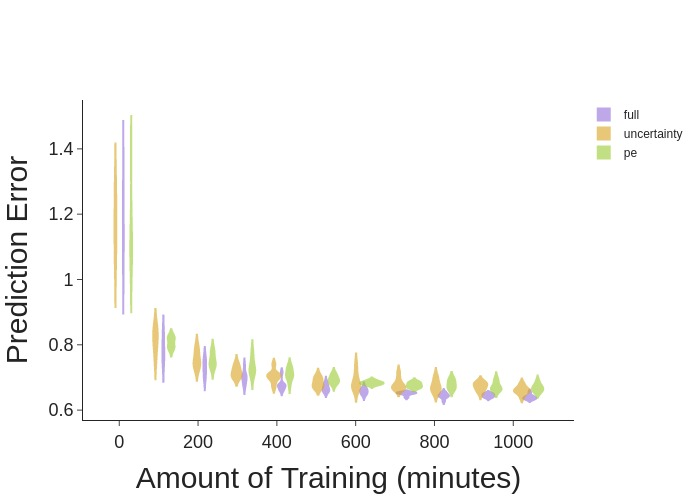

In [62]:
# compare three main models
fig = go.Figure()
# tag_names = ['full', 'uncertainty', 'pe', 'uncertainty_match_pe', 'pe_match_uncertainty']
tag_names = ['full', 'uncertainty', 'pe']
# shifts = [0, -10, 10, -20, 20]
shifts = [0, -20, 20]
widths = [50, 40, 60]
point = False
ranks = [0, 1, 2, 3, 4]


# for i, tags in enumerate([full_tags, uncertainty_tags, pe_tags, uncertainty_match_pe_tags, pe_match_uncertainty_tags]):
for i, tags in enumerate([full_tags, uncertainty_tags, pe_tags]):
    df = df_pe_long_avg[(df_pe_long_avg.variable == 'pe') & (df_pe_long_avg.tag.isin(tags))]
    fig.add_trace(
        go.Violin(x=df.training_time+shifts[i], y=df.value, name=f"{tag_names[i]}", 
                  fillcolor=colors[i+1], line_color=colors[i+1], opacity=0.6,
                  points=point, width=widths[i]
#                 mode='markers', marker=dict(size=5, color=colors[i+1])
                  )
    )
    

fig.update_layout(layout)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis)
fig.update_xaxes(title=dict(text="Amount of Training (minutes)"))
fig.update_yaxes(title=dict(text="Prediction Error"))
# fig.update_layout(title="Compare Segmentation Agreement Between Full and Lesioned Models", title_x=0.5)
fig.show()

In [88]:
fig.write_html('pe_3_models.html')

### Statistical Tests

In [236]:
df_pe_long_end = df_pe_long_avg[df_pe_long_avg.epoch > 90]

In [237]:
uncertainty_sample = df_pe_long_end[df_pe_long_end['tag'].isin(uncertainty_tags) & (df_pe_long_end['variable'] == 'pe')]['value'] 
full_sample = df_pe_long_end[df_pe_long_end['tag'].isin(full_tags) & (df_pe_long_end['variable'] == 'pe')]['value']
pe_sample = df_pe_long_end[df_pe_long_end['tag'].isin(pe_tags) & (df_pe_long_end['variable'] == 'pe')]['value']

In [239]:
tstat, pvalue = stats.ttest_ind(uncertainty_sample, pe_sample, alternative='two-sided', equal_var=False)
degree_freedom = len(uncertainty_sample) + len(full_sample) - 2
print(f"t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")

t-statistics=-0.85, p-value=0.4, df=30


In [243]:
tstat, pvalue = stats.ttest_ind(full_sample, pe_sample, alternative='two-sided', equal_var=False)
degree_freedom = len(pe_sample) + len(full_sample) - 2
print(f"two-sided t-test, t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")

two-sided t-test, t-statistics=-7.96, p-value=5.4e-08, df=30


In [245]:
tstat, pvalue = stats.ttest_ind(full_sample, uncertainty_sample, alternative='two-sided', equal_var=False)
degree_freedom = len(uncertainty_sample) + len(full_sample) - 2
print(f"two-sided t-test, t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")

two-sided t-test, t-statistics=-6.40, p-value=2.2e-06, df=30


## Compare to Generic Models

In [100]:
df_pe_select = df_pe_long_avg[df_pe_long_avg.tag.isin(update_tags_3m17_more)]
df_pe_select

,epoch,tag,variable,value,training_time
188,1,july_18_full_.8_.8_1010_1E-03_1E-01_1E+07,pe,1.533384,10.481734
189,1,july_18_full_.8_.8_1010_1E-03_1E-01_1E+07,pe_w,1.139223,10.481734
190,1,july_18_full_.8_.8_1010_1E-03_1E-01_1E+07,pe_w2,1.070448,10.481734
191,1,july_18_full_.8_.8_1010_1E-03_1E-01_1E+07,pe_w3,1.027474,10.481734
192,1,july_18_full_.8_.8_1020_1E-03_1E-01_1E+07,pe,1.207254,10.481734
...,...,...,...,...,...
2435,101,july_18_full_.8_.8_1150_1E-03_1E-01_1E+07,pe_w3,0.539205,1044.249744
2436,101,july_18_full_.8_.8_1160_1E-03_1E-01_1E+07,pe,0.593539,1044.249744
2437,101,july_18_full_.8_.8_1160_1E-03_1E-01_1E+07,pe_w,0.800881,1044.249744
2438,101,july_18_full_.8_.8_1160_1E-03_1E-01_1E+07,pe_w2,0.609405,1044.249744


In [ ]:
# retain run
df_pe_select = df_pe_select.groupby(['tag', 'training_time', 'run', 'variable'])
df_pe_select = df_pe_select.agg({'value': ['mean', 'std']}).reset_index()
df_pe_select.columns = ['_'.join(col) if len(col[1]) > 0 else col[0] for col in df_pe_select.columns]
# line_size = df_pe_select.groupby(['tag', 'run', 'variable'])['value_std'].mean().reset_index()
df_pe_select

In [57]:
# average for all validation runs
df_pe_select = df_pe_select.groupby(['tag', 'training_time', 'variable'])
df_pe_select = df_pe_select.agg({'value': ['mean', 'std']}).reset_index()
df_pe_select.columns = ['_'.join(col) if len(col[1]) > 0 else col[0] for col in df_pe_select.columns]
df_pe_select.tail()

,tag,training_time,variable,value_mean,value_std
699,july_18_full_.8_.8_1160_1E-03_1E-01_1E+07,937.848032,pe_w3,0.528536,NaN
700,july_18_full_.8_.8_1160_1E-03_1E-01_1E+07,1044.249744,pe,0.593539,NaN
701,july_18_full_.8_.8_1160_1E-03_1E-01_1E+07,1044.249744,pe_w,0.800881,NaN
702,july_18_full_.8_.8_1160_1E-03_1E-01_1E+07,1044.249744,pe_w2,0.609405,NaN
703,july_18_full_.8_.8_1160_1E-03_1E-01_1E+07,1044.249744,pe_w3,0.513498,NaN


In [101]:
# average for all validation runs, across tags (to plot error bars)
import scipy.stats as stat
df_pe_select = df_pe_select.groupby(['training_time', 'variable'])
df_pe_select = df_pe_select.agg({'value': ['mean', 'std', stat.sem]}).reset_index()
df_pe_select.columns = ['_'.join(col) if len(col[1]) > 0 else col[0] for col in df_pe_select.columns]
df_pe_select.tail()

,training_time,variable,value_mean,value_std,value_sem
39,937.848032,pe_w3,0.511009,0.021010,0.005253
40,1044.249744,pe,0.576904,0.015798,0.003949
41,1044.249744,pe_w,0.654347,0.075147,0.018787
42,1044.249744,pe_w2,0.551354,0.032020,0.008005
43,1044.249744,pe_w3,0.514886,0.024746,0.006186


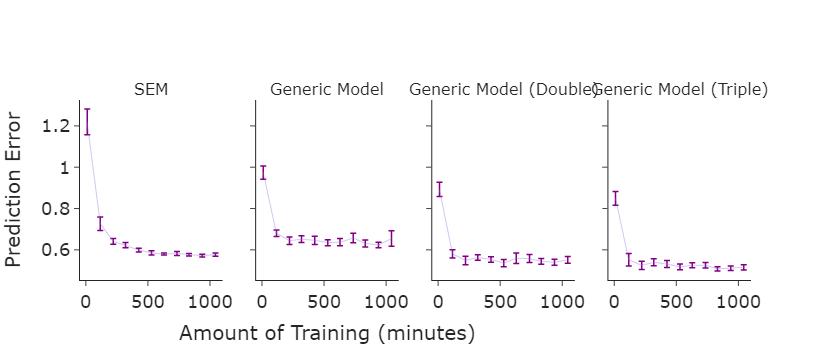

In [104]:
from plotly.subplots import make_subplots
pe_names = ['SEM', 'Generic Model', 'Generic Model (Double)', 'Generic Model (Triple)']
fig = make_subplots(
                    shared_yaxes=True,
                    rows=1, cols=4, 
                    subplot_titles=tuple(pe_names)
                   )
tag_names = ['SEM-2.0']
shifts = [-10, 10, 0, 0, 20, -20]
point = False
width = 50
# line_size = [2, 2, 4, 2]
# ranks = [0, 1, 2, 3, 4, 5]


for j, var in enumerate(['pe', 'pe_w', 'pe_w2', 'pe_w3']):
    df = df_pe_select[(df_pe_select.variable == var)]
    df = df.sort_values(by='training_time')
    # ls = float(line_size[(line_size.variable == var)]['value_std'])
    fig.add_trace(
        go.Scatter(x=df.training_time, y=df[f'value_mean'], 
                   mode="lines", 
                   # legendrank=ranks[i], 
                   fillcolor=colors[i+1], line_color=colors[i+1], 
                   error_y=dict(
                        type='data',
                        array=df[f'value_sem'].to_numpy() * 2,
                        color='purple',
                        thickness=1.5,
                        width=3,
                    ),
                   line=dict(width=0.4),
                   # points=point, width=width
                  ),
        row=j // 4 + 1, col=j % 4 + 1
    )
    

fig.update_layout(layout, 
                  # width=800, height=500, title_text="", 
                  # legend={'traceorder':'grouped'}
                 )
fig.update_xaxes(x_axis)
fig.update_xaxes(
                 title_text="Amount of Training (minutes)", row=1, col=2
                )
fig.update_yaxes(y_axis, title_text="Prediction Error", row=1, col=1)
fig.update_layout(#title=dict(text="Purity of SEM Action Categorization"),
                 showlegend=False)
# fig.update_layout(title_text="Average PE for all Validation activities (all simulations)")
# fig.for_each_annotation(lambda a: a.update(text=model_names[a.text.split('=')[-1]]))
# fig.update_xaxes(title_text="Amount of Training (minutes)")
# fig.update_yaxes(title_text=f"{metric}")

fig.show()

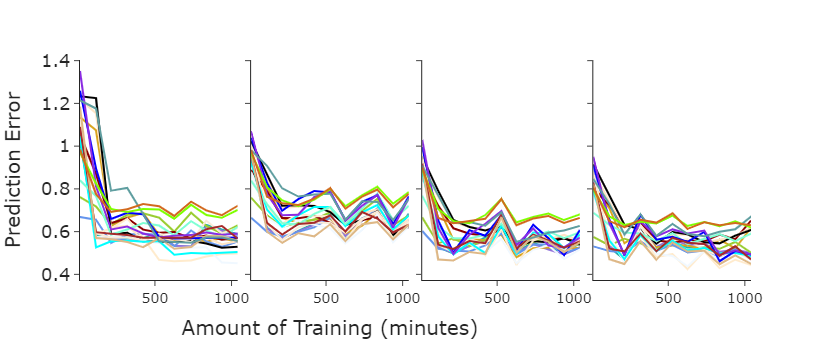

In [329]:
fig = px.line(data_frame=df_pe_select[df_pe_select.tag == update_tags_3m17_more[7]], 
                 x='training_time', y='value_mean', facet_col='variable', 
                 # facet_col_wrap=2,
                 color='run', color_discrete_sequence=colors,
                 labels=dict(value="Prediction Error", training_time="") 
                )
fig.update_layout(layout)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis, title_text='Prediction Error', row=1, col=1)
fig.update_layout(#title=dict(text="Compare Prediction Errors between SEM and Generic Models"),
                 showlegend=False)
fig.update_xaxes(tickfont=dict(size=14))
fig.update_xaxes(title_text="\t\t\t\tAmount of Training (minutes)", row=1, col=2)
model_names = {'pe': 'SEM', 'pe_w': 'Generic Model', 'pe_w2': 'Generic Model (Double)',
               'pe_w3': 'Generic Model (Triple)'}
# fig.for_each_annotation(lambda a: a.update(text=model_names[a.text.split('=')[-1]], font_size=16))
fig.for_each_annotation(lambda a: a.update(text='', font_size=16))
# fig.update_traces(opacity=.5, selector=dict(type='scatter'))
# line_size = [2, 2, 4, 2]
# fig.update_traces(opacity=.5, line=dict(width=line_size[2]), selector=dict(type='scatter'))
# fig.update_traces(marker=dict(opacity=1.0), selector=dict(type='scatter'))
# fig.update_layout(title_text="Average PE for all Validation activities (single simulation)")
fig.show()

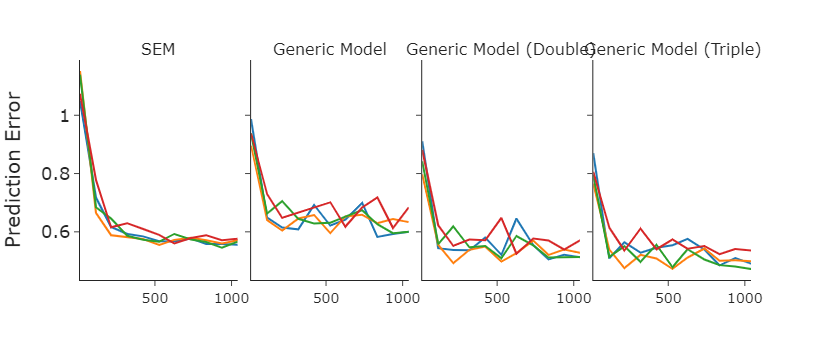

In [333]:
fig = px.line(data_frame=df_pe_select[df_pe_select.tag.isin(update_tags_3m17_more[4:8])], 
                 x='training_time', y='value_mean', facet_col='variable', 
                 # facet_col_wrap=2,
                 # trendline='rolling', trendline_options={'window': 1},
                 # opacity=0.6, 
                 color='tag',
                 labels=dict(value="Prediction Error", training_time="") 
                )
fig.update_layout(layout)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis, title_text="Prediction Error", row=1, col=1)
fig.update_layout(#title=dict(text="Compare Prediction Errors between SEM and Generic Models"),
                 showlegend=False)
fig.update_xaxes(tickfont=dict(size=14))
# fig.update_xaxes(title_text="\t\t\t\tAmount of Training (minutes)", row=1, col=2)
model_names = {'pe': 'SEM', 'pe_w': 'Generic Model', 'pe_w2': 'Generic Model (Double)',
               'pe_w3': 'Generic Model (Triple)'}
fig.for_each_annotation(lambda a: a.update(text=model_names[a.text.split('=')[-1]], font_size=16))
# fig.update_traces(opacity=.5, selector=dict(type='scatter'))
fig.update_traces(marker=dict(opacity=1.0), selector=dict(type='scatter'))

fig.show()

#### Statistical Tests

In [346]:
df_pe_end = df_pe_select[df_pe_select.training_time > 800]
import scipy.stats as stat
df_pe_end = df_pe_end.groupby(['variable'])[['value_mean']].agg({'value_mean': ['count', 'mean', stat.sem, 'std']}).reset_index()
df_pe_end

variable value_mean                              
                count      mean       sem       std
0       pe         48  0.574791  0.001983  0.013741
1     pe_w         48  0.636329  0.007337  0.050833
2    pe_w2         48  0.545121  0.004235  0.029341
3    pe_w3         48  0.511318  0.003183  0.022051

In [352]:
# 95% CI
df_pe_end['ci_lower'] = df_pe_end['value_mean']['mean'] + df_pe_end['value_mean']['sem'] * stat.t.ppf(q=.025,df=48)
df_pe_end['ci_upper'] = df_pe_end['value_mean']['mean'] + df_pe_end['value_mean']['sem'] * stat.t.ppf(q=.975,df=48)
df_pe_end

variable value_mean                                ci_lower  ci_upper
                count      mean       sem       std                    
0       pe         48  0.574791  0.001983  0.013741  0.570803  0.578779
1     pe_w         48  0.636329  0.007337  0.050833  0.621577  0.651081
2    pe_w2         48  0.545121  0.004235  0.029341  0.536606  0.553636
3    pe_w3         48  0.511318  0.003183  0.022051  0.504918  0.517717

In [120]:
# mean PE at the end of training
df_pe_select = df_pe_long_avg[df_pe_long_avg.tag.isin(full_tags)]
df_pe_end = df_pe_select[df_pe_select.training_time > 800]
df_pe_end
stats.ttest_ind(df_pe_end[df_pe_end['variable'] == 'pe']['value'],
                df_pe_end[df_pe_end['variable'] == 'pe_w2']['value'],
                alternative='greater')

Ttest_indResult(statistic=6.344544993775727, pvalue=3.8841530303107665e-09)

In [ ]:
# interference
df_pe = deepcopy(schemadf[['run', 'epoch', 'pe', 'pe_w', 'pe_w2', 'pe_w3', 'tag']])
df_pe = df_pe[df_pe.run.isin(valid_runs)]
df_pe.epoch = df_pe.epoch.astype(int)
df_pe = df_pe.groupby(['epoch', 'run', 'tag']).mean().reset_index(level=['epoch', 'run', 'tag'])
df_pe_long = pd.melt(df_pe, id_vars=["epoch", "run", "tag"], value_vars=['pe', 'pe_w', 'pe_w2', 'pe_w3'])
df_pe_long

## Parcelized PE

In [63]:
def pe_epoch(sdf, e):
    if int(e) % 10 != 1:
        return pd.DataFrame()
    df_e = pd.DataFrame(columns=['tag', 'epoch', 'run', 
                                 'pe', 'pe_appear', 'pe_optical', 
                                 'pe_skel', 'pe_emb', 'is_sum'])
    # for each tag
    for tag in tqdm(sdf.tag.unique()):
        for run in sdf.run.unique():
            try:
                diag = pkl.load(open(f'output/run_sem/{tag}/{run}_kinect_trim{tag}_diagnostic_{e}.pkl', 'rb'))
                pe = (diag['x_hat'] - diag['x'])
                full_pe = np.linalg.norm(pe, axis=1).mean() / np.sqrt(30)
                appear_pe = np.linalg.norm(pe[:, :2], axis=1).mean() / np.sqrt(2)
                optical_pe = np.linalg.norm(pe[:, :3], axis=1).mean() / np.sqrt(1)
                skel_pe = np.linalg.norm(pe[:, 3:17], axis=1).mean() / np.sqrt(14)
                emb_pe = np.linalg.norm(pe[:, 17:], axis=1).mean() / np.sqrt(13)
                identifier = [tag, e, run]
                pe_list = [full_pe, appear_pe, optical_pe, skel_pe, emb_pe]
                # df_e.loc[len(df_e), :] = identifier + [np.sum(x) for x in pe_list] + [1]
                df_e.loc[len(df_e), :] = identifier + [np.average(x) for x in pe_list] + [0]
            except Exception as ex:
                print(ex)
                continue
    return df_e

In [ ]:
sdf = schema_df[schema_df.tag.isin(full_tags + 
                                 full_nosema_tags[:8] + 
                                 full_noskel_tags[:8])]
sdf = sdf[sdf.run.isin(valid_runs)]
pe_epoch(sdf, 101)

In [ ]:
sdf = schema_df[schema_df.tag.isin(full_tags + 
                                 full_nosema_tags[:8] + 
                                 full_noskel_tags[:8])]
sdf = sdf[sdf.run.isin(valid_runs)]
df_parcels = Parallel(n_jobs=8)(delayed(pe_epoch)(sdf, e) for e in (sdf.epoch.unique()))
df_parcel = pd.concat(df_parcels)
# df_parcel.columns = ['tag', 'epoch', 'run', 
#                      'pe', 'pe_appear', 'pe_optical', 
#                      'pe_skel', 'pe_emb', 'is_sum']

In [70]:
df_parcel.to_csv('df_parcel_final.csv', index_label=False)

In [71]:
df_parcel = pd.read_csv('df_parcel_final.csv')
df_parcel.tag.unique()

array(['april_17_always_s1090_1E-01_5E+05',
       'april_17_always_s1140_1E-01_5E+05',
       'april_17_always_s1120_1E-01_5E+05',
       'april_17_always_s1020_1E-01_5E+05',
       'april_17_always_s1070_1E-01_5E+05',
       'april_17_always_s1030_1E-01_5E+05',
       'april_17_always_s1110_1E-01_5E+05',
       'april_17_always_s1100_1E-01_5E+05',
       'april_21_noskel_s1020_1E-01_5E+05',
       'april_21_noskel_s1140_1E-01_5E+05',
       'april_21_noskel_s1110_1E-01_5E+05',
       'april_21_noskel_s1120_1E-01_5E+05',
       'april_21_noskel_s1010_1E-01_5E+05',
       'april_21_noskel_s1070_1E-01_5E+05',
       'april_21_noskel_s1270_1E-01_5E+05',
       'april_21_noskel_s1060_1E-01_5E+05',
       'april_24_nosema_s1270_1E-01_5E+05',
       'april_24_nosema_s1020_1E-01_5E+05',
       'april_24_nosema_s1040_1E-01_5E+05',
       'april_24_nosema_s1210_1E-01_5E+05',
       'april_24_nosema_s1250_1E-01_5E+05',
       'april_24_nosema_s1030_1E-01_5E+05',
       'april_24_nosema_s1150_1E

In [72]:
df_parcel_long = pd.melt(df_parcel, id_vars=["epoch", "run", "tag", "is_sum"], 
                         value_vars=['pe', 'pe_appear', 'pe_optical', 'pe_skel', 'pe_emb'])

In [73]:
df_parcel_long['training_time'] = df_parcel_long['epoch'].map(epoch_to_duration)
df_parcel_long['training_time'] = df_parcel_long['training_time'] / 60
df_parcel_long.head(5)

,epoch,run,tag,is_sum,variable,value,training_time
0,51,1.1.6,april_17_always_s1090_1E-01_5E+05,0,pe,0.125862,524.532086
1,51,3.4.3,april_17_always_s1090_1E-01_5E+05,0,pe,0.099668,524.532086
2,51,2.4.9,april_17_always_s1090_1E-01_5E+05,0,pe,0.102901,524.532086
3,51,6.3.8,april_17_always_s1090_1E-01_5E+05,0,pe,0.149574,524.532086
4,51,2.2.1,april_17_always_s1090_1E-01_5E+05,0,pe,0.116526,524.532086


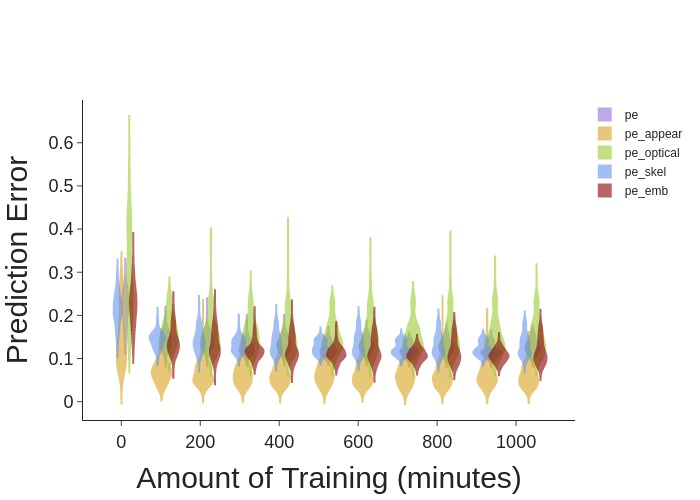

In [74]:
# fig = px.violin(bi_df_long[bi_df_long.variable != 'bi'], x="epoch", y="value", color="tag",
#                 title="Segmentation Agreement with Human Subjects")
fig = go.Figure()
tag_names = ['Full', 'Appearance-Disappeance', 'Optical', 'Motion', 'Object-Hand']
point = False
width = 50
shifts = [0, -10, 10, -20, 20]

# df = df_pe_long[(bi_df_long.variable == 'bi_shuffle_h_fair') & (bi_df_long.tag.isin(full_tags))]
# fig.add_trace(
#     go.Violin(x=df.training_time, y=df.value, name=f"Perm", 
#               fillcolor=colors[0], line_color=colors[0], opacity=0.6, points=False, width=30)
# )
for i, var in enumerate(['pe', 'pe_appear', 'pe_optical', 'pe_skel', 'pe_emb']):
    df = df_parcel_long[(df_parcel_long.variable == var) & (df_parcel_long.is_sum == False)]
    fig.add_trace(
        go.Violin(x=df.training_time + shifts[i], y=df.value, name=f"{var}", 
                  fillcolor=colors[i+1], line_color=colors[i+1], opacity=0.6,
                  points=point, width=width)
    )
    

fig.update_layout(layout)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis)
fig.update_xaxes(title=dict(text="Amount of Training (minutes)"))
fig.update_yaxes(title=dict(text="Prediction Error"))
# fig.update_layout(title="Compare Segmentation Agreement Between Full and Lesioned Models", title_x=0.5)
fig.show()

In [79]:
df_parcel_long = df_parcel_long.groupby(['epoch', 'tag', 'variable', 'training_time'])['value'].mean().reset_index()
df_parcel_long['Model Version'] = None
df_parcel_long.loc[df_parcel_long.tag.isin(full_tags), 'Model Version'] = 'SEM-2.0-full'
df_parcel_long.loc[df_parcel_long.tag.isin(full_noskel_tags), 'Model Version'] = 'Motion-deprived'
df_parcel_long.loc[df_parcel_long.tag.isin(full_nosema_tags), 'Model Version'] = 'Semantics-deprived'
df_parcel_long.head(5)

,epoch,tag,variable,training_time,value,Model Version
0,1,april_17_always_s1020_1E-01_5E+05,pe,10.303168,0.214648,SEM-2.0-full
1,1,april_17_always_s1020_1E-01_5E+05,pe_appear,10.303168,0.207502,SEM-2.0-full
2,1,april_17_always_s1020_1E-01_5E+05,pe_emb,10.303168,0.211767,SEM-2.0-full
3,1,april_17_always_s1020_1E-01_5E+05,pe_optical,10.303168,0.348898,SEM-2.0-full
4,1,april_17_always_s1020_1E-01_5E+05,pe_skel,10.303168,0.209321,SEM-2.0-full


In [76]:
times = df_parcel_long.training_time.unique()

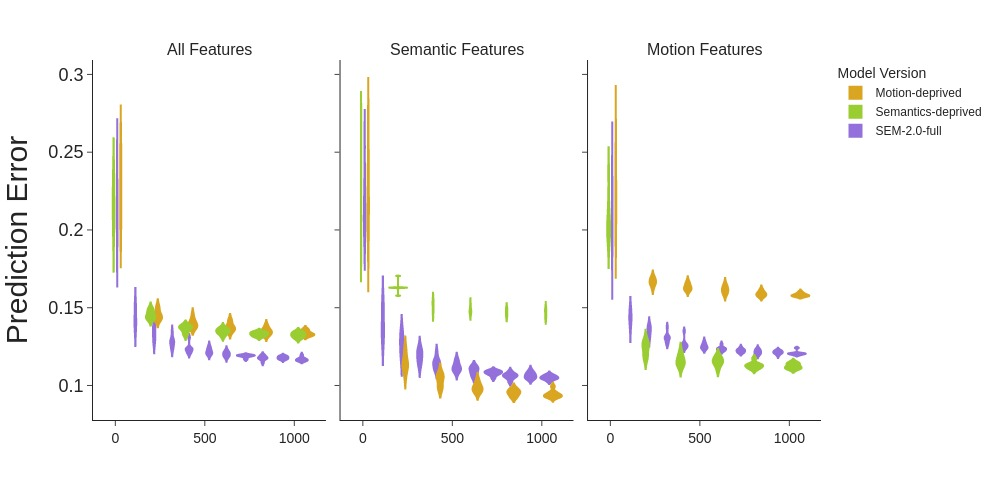

In [78]:
df_parcel_select = df_parcel_long[df_parcel_long.variable.isin(['pe', 'pe_skel', 'pe_emb'])]
df_parcel_select.loc[df_parcel_select.tag.isin(full_noskel_tags), 'training_time'] += 20
df_parcel_select.loc[df_parcel_select.tag.isin(full_nosema_tags), 'training_time'] -= 20
fig = px.violin(data_frame=df_parcel_select, 
                 x='training_time', y='value', 
                 facet_col='variable', 
                 # facet_col_wrap=2,
                 # trendline='rolling', trendline_options={'window': 1},
                 # opacity=0.6, 
                 color='Model Version',
                 color_discrete_sequence=colors[1:],
                 labels=dict(value="Prediction Error", training_time="") 
                )
fig.update_layout(layout, width=1000)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis, title_text="Prediction Error", row=1, col=1)
fig.update_layout(#title=dict(text="Compare Prediction Errors between SEM and Generic Models"),
                 showlegend=True)
fig.update_xaxes(tickfont=dict(size=14))
# fig.update_xaxes(title_text="\t\t\t\tAmount of Training (minutes)", row=1, col=2)
model_names = {'pe': 'All Features', 'pe_skel': 'Motion Features', 'pe_emb': 'Semantic Features'}
fig.for_each_annotation(lambda a: a.update(text=model_names[a.text.split('=')[-1]], font_size=16))
fig.update_traces(
                  # row=1, col=1,
                  fillcolor=colors[1], line_color=colors[1], legendrank=2,
                  width=100, points=False, scalemode="width", selector=dict(type='violin', name="SEM-2.0-full"))
fig.update_traces(
                  # row=1, col=1,
                  fillcolor=colors[2], line_color=colors[2], legendrank=0,
                  width=100, points=False, scalemode="width", selector=dict(type='violin', name="Motion-deprived"))
fig.update_traces(
                  # row=1, col=1,
                  fillcolor=colors[3], line_color=colors[3], legendrank=1,
                  width=100, points=False, scalemode="width", selector=dict(type='violin', name="Semantics-deprived"))
# fig.update_traces(marker=dict(opacity=1.0), selector=dict(type='scatter'))
# fig.update_layout(shapes=[{'type': 'line','y0':0,'y1': 0.05 * 2,'x0': t, 
#                            'x1': t,
#                            'xref':'x1','yref':'y1',
#                            'line': {'color': 'red','width': 2.5}} 
#                           for t in times])
fig.show()

# Clustering

## Mutual Information

### Prepare MI Dataframe

In [ ]:
mi_df = pd.DataFrame()
for key in name_to_tags.keys():
    tag_mi_dfs = Parallel(n_jobs=11)(delayed(compute_mi_tag)(tag) for tag in name_to_tags[key])
    mi_df = pd.concat([mi_df, pd.concat(tag_mi_dfs)])
#     mi_df.to_csv(f'./output/dataframes/group_mi_df_{key}.csv', index=False)

In [89]:
mi_df_long = pd.melt(mi_df, id_vars = ["epoch", "tag"], value_vars=['mi', 'mi_shuffle'])
mi_df_long = mi_df_long.drop_duplicates()

In [90]:
mi_df_long['training_time'] = mi_df_long['epoch'].map(epoch_to_duration)
mi_df_long['training_time'] = mi_df_long['training_time'] / 60
mi_df_long.head(5)

,epoch,tag,variable,value,training_time
0,71,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,mi,0.512479,729.010565
11,1,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,mi,0.195844,10.303168
22,101,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,mi,0.526302,1041.799201
33,81,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,mi,0.511476,823.490616
44,21,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,mi,0.500860,217.061773


### Multiple Tags, Each with Multiple Simulations

In [91]:
mi_df_long = mi_df_long[mi_df_long['training_time'] < 1100]

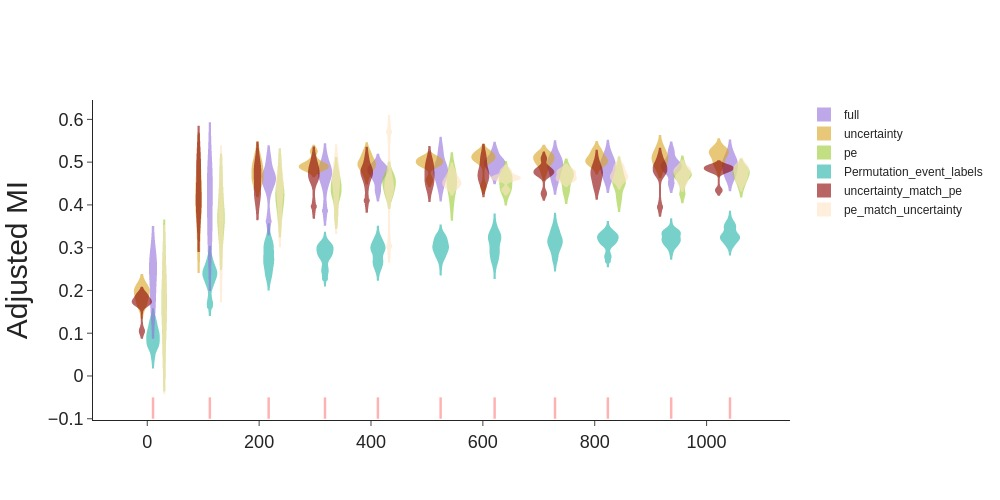

In [94]:
fig = go.Figure()
# note that there is no humans for MI, just adding so that color scheme is consistent with biserial
tag_names = ['full', 'uncertainty', 'pe', 'human', 'uncertainty_match_pe', 'pe_match_uncertainty']
shifts = [0, -20, 20, 0, -20, 20, -20, 20]
widths = [35, 50, 30, 10, 50, 50, 35, 35]
point = 0
ranks = [0, 1, 2, 3, 4, 5, 6, 7]

df = mi_df_long[(mi_df_long.variable == 'mi_shuffle')
                  & (mi_df_long.tag.isin(uncertainty_tags))
                 ]
fig.add_trace(
    go.Violin(x=df.training_time, y=df.value, name=f"Permutation_event_labels", 
              fillcolor=colors[0], line_color=colors[0], opacity=0.6, points=point, width=35,
              legendrank=ranks[4])
)

for i, tags in enumerate([full_tags, uncertainty_tags, pe_tags, ['human'], 
                          uncertainty_match_pe_tags, pe_match_uncertainty_tags,
                          ]):
    df = mi_df_long[(mi_df_long.variable == 'mi') & (mi_df_long.tag.isin(tags))]
    fig.add_trace(
        go.Violin(x=df.training_time+shifts[i], y=df.value, name=f"{tag_names[i]}", 
                  fillcolor=colors[i+1], line_color=colors[i+1], opacity=0.6, 
                  points=point, width=widths[i], scalemode='count',
                  legendrank=ranks[i],
                  # mode='markers', marker=dict(size=5, color=colors[i+1])
                  )
    )
    

fig.update_layout(layout, width=1000)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis)
# fig.update_xaxes(title=dict(text="Amount of Training (minutes)"))
fig.update_yaxes(title=dict(text="Adjusted MI"))
# fig.update_layout(title="Adjusted Mutual Information", title_x=0.5)
fig.update_layout(shapes=[{'type': 'line','y0':-0.1,'y1': -0.05,'x0': t, 
                           'x1': t,
                           'xref':'x1','yref':'y1',
                           'line': {'color': 'red','width': 2.5}} 
                          for t in mi_df_long.training_time.unique()])
fig.show()

In [55]:
fig.write_html('mi_all_models.html')

#### Statistical Tests

In [95]:
mi_df_long_end = mi_df_long[mi_df_long.training_time > 900]
mi_df_long_end

,epoch,tag,variable,value,training_time
22,101,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,mi,0.526302,1041.799201
77,91,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,mi,0.518783,936.683755
198,101,feb_24_uncertainty2.5E-03_s1020_1E+00_5E-03,mi,0.505633,1041.799201
231,91,feb_24_uncertainty2.5E-03_s1020_1E+00_5E-03,mi,0.505161,936.683755
297,91,feb_24_uncertainty2.5E-03_s1030_1E+00_5E-03,mi,0.488363,936.683755
...,...,...,...,...,...
22094,101,july_30_pe_noskel_4.3E-01_s1100_2E-02_5E+00,mi_shuffle,0.278870,1041.799201
22095,101,july_30_pe_noskel_4.3E-01_s1100_2E-02_5E+00,mi_shuffle,0.257142,1041.799201
22096,101,july_30_pe_noskel_4.3E-01_s1100_2E-02_5E+00,mi_shuffle,0.261453,1041.799201
22097,101,july_30_pe_noskel_4.3E-01_s1100_2E-02_5E+00,mi_shuffle,0.278581,1041.799201


In [96]:
uncertainty_sample = mi_df_long_end[mi_df_long_end['tag'].isin(uncertainty_tags) & (mi_df_long_end['variable'] == 'mi')]['value'] 
param_match_uncertainty_sample = mi_df_long_end[mi_df_long_end['tag'].isin(uncertainty_match_pe_tags) & (mi_df_long_end['variable'] == 'mi')]['value']
full_sample = mi_df_long_end[mi_df_long_end['tag'].isin(full_tags) & (mi_df_long_end['variable'] == 'mi')]['value']
pe_sample = mi_df_long_end[mi_df_long_end['tag'].isin(pe_tags) & (mi_df_long_end['variable'] == 'mi')]['value']
param_match_pe_sample = mi_df_long_end[mi_df_long_end['tag'].isin(pe_match_uncertainty_tags) & (mi_df_long_end['variable'] == 'mi')]['value']
random_sample = mi_df_long_end[(mi_df_long_end['variable'] == 'mi_shuffle')]['value']

In [97]:
tstat, pvalue = stats.ttest_ind(uncertainty_sample, full_sample, alternative='two-sided')
degree_freedom = len(uncertainty_sample) + len(full_sample) - 2
print(f"t-statistics={tstat:.02f}, p-value={pvalue:.02e}, df={degree_freedom}")

t-statistics=3.47, p-value=1.61e-03, df=30


In [98]:
tstat, pvalue = stats.ttest_ind(uncertainty_sample, pe_sample, alternative='two-sided')
degree_freedom = len(uncertainty_sample) + len(pe_sample) - 2
print(f"t-statistics={tstat:.02f}, p-value={pvalue:.02e}, df={degree_freedom}")

t-statistics=7.68, p-value=1.45e-08, df=30


In [99]:
tstat, pvalue = stats.ttest_ind(full_sample, pe_sample, alternative='two-sided')
degree_freedom = len(full_sample) + len(pe_sample) - 2
print(f"t-statistics={tstat:.02f}, p-value={pvalue:.02e}, df={degree_freedom}")

t-statistics=3.43, p-value=1.78e-03, df=30


In [100]:
tstat, pvalue = stats.ttest_ind(full_sample, random_sample.dropna().iloc[:48], alternative='two-sided')
degree_freedom = len(full_sample) + 48 - 2
print(f"t-statistics={tstat:.02f}, p-value={pvalue:.02e}, df={degree_freedom}")

t-statistics=26.64, p-value=1.20e-35, df=62


In [101]:
tstat, pvalue = stats.ttest_ind(uncertainty_sample, random_sample.dropna().iloc[:48], alternative='two-sided')
degree_freedom = len(uncertainty_sample) + 48 - 2
print(f"t-statistics={tstat:.02f}, p-value={pvalue:.02e}, df={degree_freedom}")

t-statistics=31.67, p-value=5.42e-40, df=62


In [102]:
tstat, pvalue = stats.ttest_ind(pe_sample, random_sample.dropna().iloc[:48], alternative='two-sided')
degree_freedom = len(pe_sample) + 48 - 2
print(f"t-statistics={tstat:.02f}, p-value={pvalue:.02e}, df={degree_freedom}")

t-statistics=23.55, p-value=1.26e-32, df=62


In [103]:
tstat, pvalue = stats.ttest_ind(param_match_uncertainty_sample, pe_sample, alternative='two-sided')
degree_freedom = len(param_match_uncertainty_sample) + len(pe_sample) - 2
print(f"two-sided t-test: t-statistics={tstat:.02f}, p-value={pvalue:.02e}, df={degree_freedom}")

two-sided t-test: t-statistics=1.26, p-value=2.17e-01, df=30


In [104]:
tstat, pvalue = stats.ttest_ind(param_match_pe_sample, uncertainty_sample, alternative='two-sided')
degree_freedom = len(param_match_pe_sample) + len(uncertainty_sample) - 2
print(f"two-sided t-test: t-statistics={tstat:.02f}, p-value={pvalue:.02e}, df={degree_freedom}")

two-sided t-test: t-statistics=-7.43, p-value=4.27e-08, df=28


## Purity & Coverage

### Prepare PC Dataframe

In [ ]:
pc_df = pd.DataFrame()
for key in name_to_tags.keys():
    if key in ['full_noskel', 'full_nosema', 'uncertainty_noskel', 'pe_noskel']:
        continue
    tag_pc_dfs = Parallel(n_jobs=11)(delayed(compute_pc_tag)(tag) for tag in name_to_tags[key])
    pc_df = pd.concat([pc_df, pd.concat(tag_pc_dfs)])
#     pc_df.to_csv(f'./output/dataframes/group_pc_df_{key}.csv', index=False)

In [107]:
pc_df_long = pd.melt(pc_df, id_vars = ["epoch", "tag"], value_vars=['purity', 'purity_shuffle', 
                                                                    'coverage', 'coverage_shuffle'])
pc_df_long = pc_df_long.drop_duplicates()

In [109]:
pc_df_long['training_time'] = pc_df_long['epoch'].map(epoch_to_duration)
pc_df_long['training_time'] = pc_df_long['training_time'] / 60
pc_df_long.head(5)

,epoch,tag,variable,value,training_time
0,71,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,purity,0.378204,729.010565
11,1,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,purity,0.129876,10.303168
22,101,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,purity,0.399110,1041.799201
33,81,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,purity,0.363846,823.490616
44,21,feb_24_uncertainty2.5E-03_s1010_1E+00_5E-03,purity,0.320740,217.061773


### Multiple Tags, Each with Multiple Simulations

In [117]:
pc_df_long = pc_df_long[pc_df_long['training_time'] < 1100]

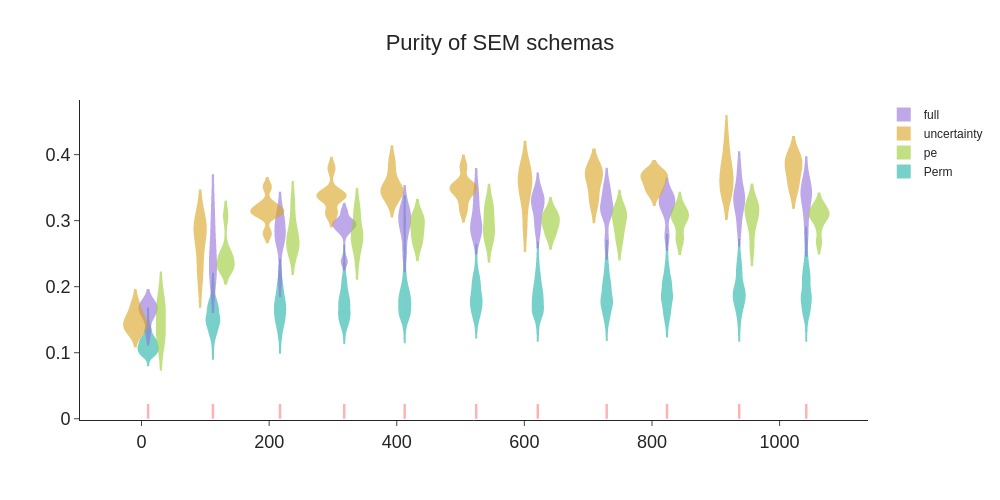

In [118]:
fig = go.Figure()
tag_names = ['full', 'uncertainty', 'pe', 'human', 'uncertainty_match_pe', 'pe_match_uncertainty']
shifts = [0, -20, 20, 0, -20, 20]
widths = [35, 50, 30, 10, 50, 50, 35, 35]
point = False
ranks = [0, 1, 2, 3, 4, 5]

df = pc_df_long[(pc_df_long.variable == 'purity_shuffle')]
fig.add_trace(
    go.Violin(x=df.training_time, y=df.value, name=f"Perm", points=point,
              fillcolor=colors[0], line_color=colors[0], opacity=0.6,
              width=30, scalemode='width', legendrank=4)
)
# df = pc_df_long[(pc_df_long.variable == 'purity_shuffle_length')]
# fig.add_trace(
#     go.Violin(x=df.training_time+30, y=df.value, name=f"Perm", points=point,
#               fillcolor=colors[2], line_color=colors[2], opacity=0.6,
#               width=width, scalemode='width')
# )
for i, tags in enumerate([full_tags, uncertainty_tags, pe_tags, ['human'],
#                           uncertainty_match_pe_tags, pe_match_uncertainty_tags
                         ]):
    df = pc_df_long[(pc_df_long.variable == 'purity') & (pc_df_long.tag.isin(tags))]
    fig.add_trace(
        go.Violin(x=df.training_time+shifts[i], y=df.value, name=tag_names[i],
                  fillcolor=colors[i+1], line_color=colors[i+1], opacity=0.6,
                  points=point, width=widths[i], scalemode='count', legendrank=ranks[i])
    )
# fig.add_annotation(x=900, y=0.42,
#         text="SEM-to-human",
#         font=dict(
#         # family="sans serif",
#         size=18,
#         color=colors[1]
#         ),
#         showarrow=False,
#         )

    

fig.update_layout(layout, width=1000)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis)
fig.update_layout(title=dict(text="Purity of SEM schemas"),
                 showlegend=True)
# fig.update_xaxes(title_text="Amount of Training (minutes)")
# fig.update_yaxes(title_text="Purity")
fig.update_layout(shapes=[{'type': 'line','y0':0,'y1': 0.05 * 0.45,'x0': t, 
                           'x1': t,
                           'xref':'x1','yref':'y1',
                           'line': {'color': 'red','width': 2.5}} 
                          for t in pc_df_long.training_time.unique()])
fig.show()

In [119]:
fig.write_html("purity_all_models.html")

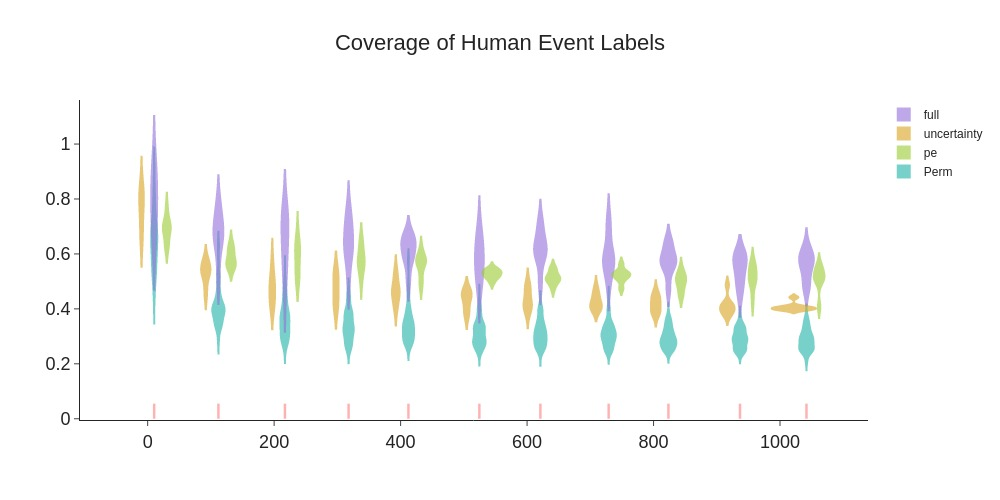

In [120]:
fig = go.Figure()
tag_names = ['full', 'uncertainty', 'pe', 'human', 'uncertainty_match_pe', 'pe_match_uncertainty']
shifts = [0, -20, 20, 0, -20, 20]
widths = [25, 70, 30, 10, 50, 50, 35, 35]
point = False
ranks = [0, 1, 2, 3, 4, 5]

# df = pc_df_long[(pc_df_long.variable == 'coverage_shuffle')]
# fig.add_trace(
#     go.Violin(x=df.training_time-30, y=df.value, name=f"Perm", points=point,
#               fillcolor=colors[0], line_color=colors[0], opacity=0.6,
#               width=width, scalemode='width')
# )
df = pc_df_long[(pc_df_long.variable == 'coverage_shuffle')]
fig.add_trace(
    go.Violin(x=df.training_time, y=df.value, name=f"Perm", points=point,
              fillcolor=colors[0], line_color=colors[0], opacity=0.6,
              width=25, scalemode='width', legendrank=ranks[3])
)
for i, tags in enumerate([full_tags, uncertainty_tags, pe_tags, ['human'],
#                           uncertainty_match_pe_tags, pe_match_uncertainty_tags
                         ]):
    df = pc_df_long[(pc_df_long.variable == 'coverage') & (pc_df_long.tag.isin(tags))]
    fig.add_trace(
        go.Violin(x=df.training_time+shifts[i], y=df.value, name=tag_names[i],
                  fillcolor=colors[i+1], line_color=colors[i+1], opacity=0.6,
                  points=point, width=widths[i], scalemode='width', legendrank=ranks[i])
    )
    
# fig.add_annotation(x=900, y=1.1,
#         text="SEM-to-human",
#         font=dict(
#         # family="sans serif",
#         size=18,
#         color=colors[1]
#         ),
#         showarrow=False,
#         )
# fig.add_annotation(x=900, y=0.08,
#         text="event-length-and-activation-time",
#         font=dict(
#         # family="sans serif",
#         size=18,
#         color=colors[0]
#         ),
#         showarrow=False,
#         )
# fig.add_annotation(x=1300, y=0.2,
#         text="only-event-length",
#         font=dict(
#         # family="sans serif",
#         size=18,
#         color=colors[2]
#         ),
#         showarrow=False,
#         )
    
fig.update_layout(layout, width=1000)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis)
fig.update_layout(title=dict(text="Coverage of Human Event Labels"),
                 showlegend=True)
# fig.update_xaxes(title_text="Amount of Training (minutes)")
# fig.update_yaxes(title_text="Coverage")
fig.update_layout(shapes=[{'type': 'line','y0':0,'y1': 0.05 * 1.1,'x0': t, 
                           'x1': t,
                           'xref':'x1','yref':'y1',
                           'line': {'color': 'red','width': 2.5}} 
                          for t in pc_df_long.training_time.unique()])
fig.show()

In [121]:
fig.write_html("coverage_all_models.html")

#### Statistical Tests PC

##### Coverage

In [122]:
pc_df_long_end = pc_df_long[pc_df_long.training_time > 900]

uncertainty_sample = pc_df_long_end[pc_df_long_end['tag'].isin(uncertainty_tags) & (pc_df_long_end['variable'] == 'coverage')]['value'] 
param_match_uncertainty_sample = pc_df_long_end[pc_df_long_end['tag'].isin(uncertainty_match_pe_tags) & (pc_df_long_end['variable'] == 'coverage')]['value'] 
full_sample = pc_df_long_end[pc_df_long_end['tag'].isin(full_tags) & (pc_df_long_end['variable'] == 'coverage')]['value']
pe_sample = pc_df_long_end[pc_df_long_end['tag'].isin(pe_tags) & (pc_df_long_end['variable'] == 'coverage')]['value']
param_match_pe_sample = pc_df_long_end[pc_df_long_end['tag'].isin(pe_match_uncertainty_tags) & (pc_df_long_end['variable'] == 'coverage')]['value']
random_sample = pc_df_long_end[(pc_df_long_end['variable'] == 'coverage_shuffle')]['value']
human_sample = pc_df_long_end[(pc_df_long_end['variable'] == 'human')]['value']

In [123]:
tstat, pvalue = stats.ttest_ind(full_sample, random_sample.dropna()[:16], alternative='two-sided', equal_var=False)
degree_freedom = len(full_sample) + len(pe_sample) - 2
print(f"two-sided t-test: t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")
tstat, pvalue = stats.ttest_ind(uncertainty_sample, random_sample.dropna()[:16], alternative='two-sided', equal_var=False)
degree_freedom = len(full_sample) + len(pe_sample) - 2
print(f"two-sided t-test: t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")
tstat, pvalue = stats.ttest_ind(pe_sample, random_sample.dropna()[:16], alternative='two-sided', equal_var=False)
degree_freedom = len(full_sample) + len(pe_sample) - 2
print(f"two-sided t-test: t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")
print('---')
tstat, pvalue = stats.ttest_ind(full_sample, uncertainty_sample, alternative='two-sided', equal_var=False)
degree_freedom = len(full_sample) + len(pe_sample) - 2
print(f"two-sided t-test SEM-2.0 vs. uncertainty-SEM: t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")
tstat, pvalue = stats.ttest_ind(full_sample, pe_sample, alternative='two-sided', equal_var=False)
degree_freedom = len(full_sample) + len(pe_sample) - 2
print(f"two-sided t-test SEM-2.0 vs. pe-SEM: t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")
tstat, pvalue = stats.ttest_ind(uncertainty_sample, pe_sample, alternative='two-sided', equal_var=False)
degree_freedom = len(full_sample) + len(pe_sample) - 2
print(f"two-sided t-test uncertainty-SEM sv. pe-SEM: t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")

two-sided t-test: t-statistics=23.56, p-value=1.8e-13, df=30
two-sided t-test: t-statistics=24.39, p-value=2.4e-14, df=30
two-sided t-test: t-statistics=24.11, p-value=1e-13, df=30
---
two-sided t-test SEM-2.0 vs. uncertainty-SEM: t-statistics=9.89, p-value=1.4e-09, df=30
two-sided t-test SEM-2.0 vs. pe-SEM: t-statistics=2.23, p-value=0.034, df=30
two-sided t-test uncertainty-SEM sv. pe-SEM: t-statistics=-8.21, p-value=1.8e-08, df=30


In [124]:
pc_df_long_end = pc_df_long[pc_df_long.training_time > 900]

uncertainty_sample = pc_df_long_end[pc_df_long_end['tag'].isin(uncertainty_tags) & (pc_df_long_end['variable'] == 'purity')]['value'] 
param_match_uncertainty_sample = pc_df_long_end[pc_df_long_end['tag'].isin(uncertainty_match_pe_tags) & (pc_df_long_end['variable'] == 'purity')]['value'] 
full_sample = pc_df_long_end[pc_df_long_end['tag'].isin(full_tags) & (pc_df_long_end['variable'] == 'purity')]['value']
pe_sample = pc_df_long_end[pc_df_long_end['tag'].isin(pe_tags) & (pc_df_long_end['variable'] == 'purity')]['value']
param_match_pe_sample = pc_df_long_end[pc_df_long_end['tag'].isin(pe_match_uncertainty_tags) & (pc_df_long_end['variable'] == 'purity')]['value']
random_sample = pc_df_long_end[(pc_df_long_end['variable'] == 'purity_shuffle')]['value']
human_sample = pc_df_long_end[(pc_df_long_end['variable'] == 'human')]['value']

In [125]:
tstat, pvalue = stats.ttest_ind(full_sample, random_sample.dropna()[:16], alternative='two-sided', equal_var=False)
degree_freedom = len(full_sample) + len(pe_sample) - 2
print(f"two-sided t-test: t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")
tstat, pvalue = stats.ttest_ind(uncertainty_sample, random_sample.dropna()[:16], alternative='two-sided', equal_var=False)
degree_freedom = len(full_sample) + len(pe_sample) - 2
print(f"two-sided t-test: t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")
tstat, pvalue = stats.ttest_ind(pe_sample, random_sample.dropna()[:16], alternative='two-sided', equal_var=False)
degree_freedom = len(full_sample) + len(pe_sample) - 2
print(f"two-sided t-test: t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")

print('---')
tstat, pvalue = stats.ttest_ind(full_sample, uncertainty_sample, alternative='two-sided', equal_var=False)
degree_freedom = len(full_sample) + len(pe_sample) - 2
print(f"two-sided t-test SEM-2.0 vs. uncertainty-SEM: t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")
tstat, pvalue = stats.ttest_ind(full_sample, pe_sample, alternative='two-sided', equal_var=False)
degree_freedom = len(full_sample) + len(pe_sample) - 2
print(f"two-sided t-test SEM-2.0 vs. pe-SEM: t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")
tstat, pvalue = stats.ttest_ind(uncertainty_sample, pe_sample, alternative='two-sided', equal_var=False)
degree_freedom = len(full_sample) + len(pe_sample) - 2
print(f"two-sided t-test uncertainty-SEM sv. pe-SEM: t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")

two-sided t-test: t-statistics=13.07, p-value=6.6e-11, df=30
two-sided t-test: t-statistics=20.63, p-value=9.9e-15, df=30
two-sided t-test: t-statistics=11.22, p-value=2.3e-10, df=30
---
two-sided t-test SEM-2.0 vs. uncertainty-SEM: t-statistics=-4.80, p-value=4.1e-05, df=30
two-sided t-test SEM-2.0 vs. pe-SEM: t-statistics=3.31, p-value=0.0026, df=30
two-sided t-test uncertainty-SEM sv. pe-SEM: t-statistics=8.87, p-value=8.6e-10, df=30


# Metrics from DF

In [58]:
event_df = pd.read_csv('output/run_sem/stats_with_ratio.csv')
event_df.run = event_df.run.apply(lambda x: x.split('_')[0])
event_df.head(5)

/home/n.tan/.conda/envs/sem-viz-jupyter/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning:

Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.



,run,grain,bicorr,percentile_to_human,n_event_models,active_event_models,epoch,n_boundaries,sem_params,tag,...,n_triggers,n_timesteps,distance_to_null,pe_unc_corr,t_stat_biserial,mi,n_boundaries_adjusted,t_stat_biserial_adjusted,bicorr_adjusted,bicorr_random_adjusted
0,3.4.6,coarse,NaN,NaN,0.0,1.0,1.0,0.0,"{'lmda': 100000000.0, 'alfa': 0.0001, 'kappa':...",test_sem_sep_09,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.4.6,fine,NaN,NaN,0.0,1.0,1.0,0.0,"{'lmda': 100000000.0, 'alfa': 0.0001, 'kappa':...",test_sem_sep_09,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.1.8,coarse,NaN,NaN,0.0,1.0,1.0,0.0,"{'lmda': 100000000.0, 'alfa': 0.0001, 'kappa':...",test_sem_sep_09,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.1.8,fine,NaN,NaN,0.0,1.0,1.0,0.0,"{'lmda': 100000000.0, 'alfa': 0.0001, 'kappa':...",test_sem_sep_09,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.4.1,coarse,NaN,NaN,0.0,1.0,1.0,0.0,"{'lmda': 100000000.0, 'alfa': 0.0001, 'kappa':...",test_sem_sep_09,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
event_df = event_df[event_df.tag.isin(full_tags + uncertainty_tags + pe_tags)]

### Multi tags, multi metrics

In [60]:
# metrics = ['bicorr', 'pearson_r', 'n_event_models', 'number_boundaries', 'mean_pe', 'entropy']
# metrics = ['mean_pe', 'pearson_r', 'n_event_models', 'number_boundaries']
metrics = ['active_event_models', 'n_event_models']
n_rnns = event_df[(event_df.run.isin(valid_runs)) & (event_df.epoch % 10 == 1)]
# n_rnns = n_rnns[n_rnns.run.isin(valid_runs) & (n_rnns.grain == 'coarse')][['epoch', 'tag'] + metrics]
n_rnns = n_rnns[(n_rnns.grain == 'coarse')][['epoch', 'tag'] + metrics]
n_rnns = n_rnns.groupby(['epoch', 'tag']).mean().reset_index()
n_rnns.tail()

,epoch,tag,active_event_models,n_event_models
259,101.0,mar_15_pe4.3E-01_s1040_2E-02_5E+00,24.0,39.0
260,101.0,mar_15_pe4.3E-01_s1050_2E-02_5E+00,37.0,64.0
261,101.0,mar_15_pe4.3E-01_s1060_2E-02_5E+00,28.0,53.0
262,101.0,mar_15_pe4.3E-01_s1070_2E-02_5E+00,24.0,45.0
263,101.0,mar_15_pe4.3E-01_s1080_2E-02_5E+00,30.0,57.0


In [61]:
n_rnns_long = pd.melt(n_rnns, id_vars=["epoch", "tag"], value_vars=metrics)

In [62]:
n_rnns_long['training_time'] = n_rnns_long['epoch'].map(epoch_to_duration)
n_rnns_long['training_time'] = n_rnns_long['training_time'] / 60
n_rnns_long.head()

,epoch,tag,variable,value,training_time
0,1.0,feb_23_pe5.0E-01_s1010_2E-02_1E-01,active_event_models,0.0,10.640223
1,1.0,feb_23_pe5.0E-01_s1020_2E-02_1E-01,active_event_models,2.0,10.640223
2,1.0,feb_23_pe5.0E-01_s1030_2E-02_1E-01,active_event_models,1.0,10.640223
3,1.0,feb_23_pe5.0E-01_s1040_2E-02_1E-01,active_event_models,0.0,10.640223
4,1.0,feb_23_pe5.0E-01_s1050_2E-02_1E-01,active_event_models,2.0,10.640223


/home/n.tan/.conda/envs/sem-viz-jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



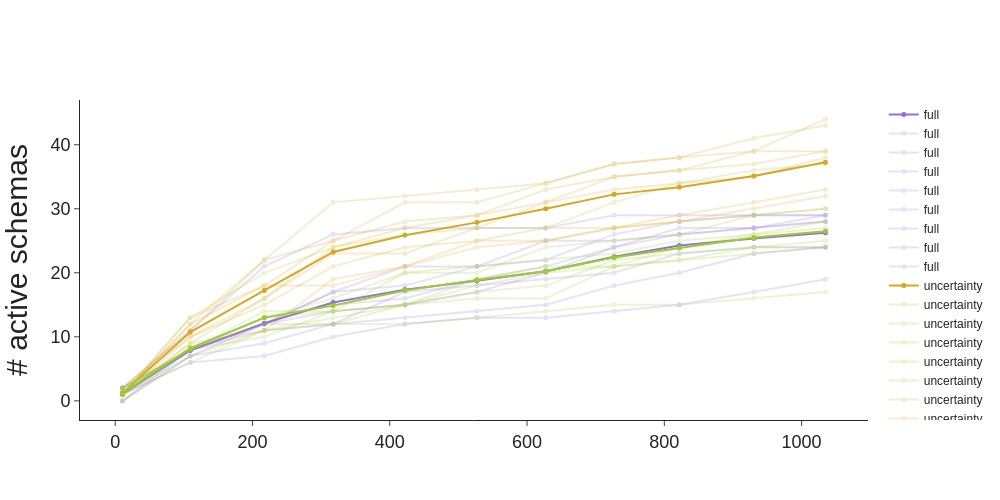

In [63]:
fig = go.Figure()
tag_names = ['full', 'uncertainty', 'pe']
shifts = [0, 0, 0, 0, -20, 20]
widths = [35, 50, 30, 10, 50, 50]
point = 0
ranks = [0, 1, 2, 3, 4, 5]

for i, tags in enumerate([full_tags, uncertainty_tags, pe_tags]):
    df = n_rnns_long[(n_rnns_long.variable == 'active_event_models') & (n_rnns_long.tag.isin(tags))]
    df_avg = df.groupby(['epoch'])['training_time', 'value'].mean()
    fig.add_trace(
        go.Scatter(x=df_avg.training_time+shifts[i], y=df_avg.value, name=f"{tag_names[i]}", 
                  fillcolor=colors[i+1], line_color=colors[i+1], opacity=1.0, 
#                   points=point, width=widths[i],
                  legendrank=ranks[i],
                  mode='markers+lines', marker=dict(size=5, color=colors[i+1])
                  )
                 )
    for t in tags:
#         df_tag = df
        df_tag = df[df.tag == t]
        fig.add_trace(
            go.Scatter(x=df_tag.training_time+shifts[i], y=df_tag.value, name=f"{tag_names[i]}", 
                      fillcolor=colors[i+1], line_color=colors[i+1], opacity=0.2, 
    #                   points=point, width=widths[i],
                      legendrank=ranks[i],
                      mode='markers+lines', marker=dict(size=5, color=colors[i+1])
                      )
                     )
    

fig.update_layout(layout, width=1000)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis)
# fig.update_xaxes(title=dict(text="Amount of Training (minutes)"))
fig.update_yaxes(title=dict(text="# active schemas"))
fig.show()

In [64]:
fig.write_html('active_schemas.html')

/home/n.tan/.conda/envs/sem-viz-jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



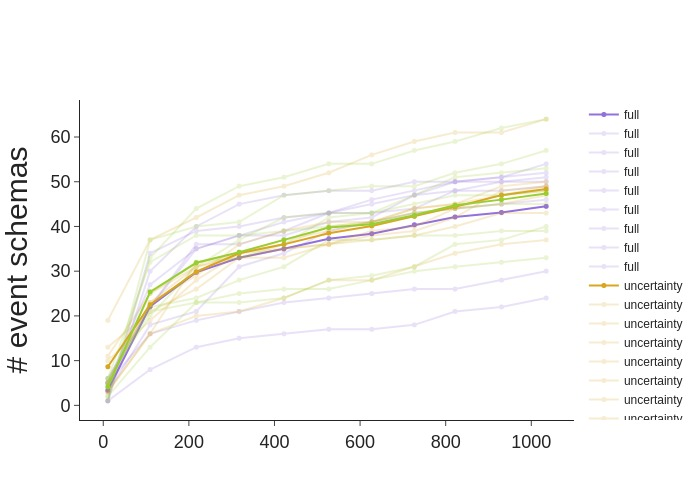

In [65]:
fig = go.Figure()
tag_names = ['full', 'uncertainty', 'pe']
shifts = [0, 0, 0, 0, -20, 20]
widths = [35, 50, 30, 10, 50, 50]
point = 0
ranks = [0, 1, 2, 3, 4, 5]

for i, tags in enumerate([full_tags, uncertainty_tags, pe_tags]):
    df = n_rnns_long[(n_rnns_long.variable == 'n_event_models') & (n_rnns_long.tag.isin(tags))]
    df_avg = df.groupby(['epoch'])['training_time', 'value'].mean()
    fig.add_trace(
        go.Scatter(x=df_avg.training_time+shifts[i], y=df_avg.value, name=f"{tag_names[i]}", 
                  fillcolor=colors[i+1], line_color=colors[i+1], opacity=1.0, 
#                   points=point, width=widths[i],
                  legendrank=ranks[i],
                  mode='markers+lines', marker=dict(size=5, color=colors[i+1])
                  )
                 )
    for t in tags:
#         df_tag = df
        df_tag = df[df.tag == t]
        fig.add_trace(
            go.Scatter(x=df_tag.training_time+shifts[i], y=df_tag.value, name=f"{tag_names[i]}", 
                      fillcolor=colors[i+1], line_color=colors[i+1], opacity=0.2, 
    #                   points=point, width=widths[i],
                      legendrank=ranks[i],
                      mode='markers+lines', marker=dict(size=5, color=colors[i+1])
                      )
                     )
    

fig.update_layout(layout)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis)
# fig.update_xaxes(title=dict(text="Amount of Training (minutes)"))
fig.update_yaxes(title=dict(text="# event schemas"))
fig.show()

In [66]:
fig.write_html('event_schemas.html')

In [221]:
n_rnns_long_end = n_rnns_long[n_rnns_long.epoch > 90]

In [222]:
uncertainty_sample = n_rnns_long_end[n_rnns_long_end['tag'].isin(uncertainty_tags) & (n_rnns_long_end['variable'] == 'active_event_models')]['value'] 
full_sample = n_rnns_long_end[n_rnns_long_end['tag'].isin(full_tags) & (n_rnns_long_end['variable'] == 'active_event_models')]['value']
pe_sample = n_rnns_long_end[n_rnns_long_end['tag'].isin(pe_tags) & (n_rnns_long_end['variable'] == 'active_event_models')]['value']

In [223]:
tstat, pvalue = stats.ttest_ind(uncertainty_sample, full_sample, alternative='two-sided', equal_var=False)
degree_freedom = len(uncertainty_sample) + len(full_sample) - 2
print(f"t-statistics={tstat:.02f}, p-value={pvalue:.02}, df={degree_freedom}")

t-statistics=4.03, p-value=0.00038, df=30


In [224]:
n_rnns['training_time'] = n_rnns['epoch'].map(epoch_to_duration)
n_rnns['training_time'] = n_rnns['training_time'] / 60
n_rnns.head()

,epoch,tag,active_event_models,n_event_models,training_time
0,1.0,april_17_always_s1020_1E-01_5E+05,1.0,4.0,10.303168
1,1.0,april_17_always_s1030_1E-01_5E+05,1.0,12.0,10.303168
2,1.0,april_17_always_s1070_1E-01_5E+05,1.0,13.0,10.303168
3,1.0,april_17_always_s1090_1E-01_5E+05,1.0,5.0,10.303168
4,1.0,april_17_always_s1100_1E-01_5E+05,1.0,6.0,10.303168


In [ ]:

fig = go.Figure()
tag_names = ['SEM-1.0', 'SEM-1.1-add_generic', 'SEM-1.2-sUP', 'SEM-1.3-generic_sUP', 'SEM-2.0', 'SEM-1.4-add_previous']
group_tags = [update_tags_pristine_3m15[:4], update_tags_w_generic_3m15[:4], \
        update_tags_wo_kappa_3m15[:4], update_tags_w_generic_wo_kappa_3m15[:4], \
        update_tags_3m15[:5], update_tags_wo_filler_3m15[:4]]
shifts = [-20, -10, 0, 10, 20, 30]


for i, tags in enumerate(group_tags):
    df = n_rnns[(n_rnns.tag.isin(tags)) & (n_rnns.epoch.isin(range(1, 62, 10)))]
    fig.add_trace(
        go.Violin(x=df.training_time+shifts[i], y=df[f'mean_pe'], name=f"{tag_names[i]}", points=False,
                  fillcolor=colors[i], line_color=colors[i], opacity=0.6,
                  width=30, scalemode='width')
    )
    

fig.update_layout(layout)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis)
fig.update_layout(
                 showlegend=True)

fig.update_layout(shapes=[{'type': 'line','y0':0.5,'y1': 0.55,'x0': t, 
                           'x1': t,
                           'xref':'x1','yref':'y1',
                           'line': {'color': 'red','width': 2.5}} 
                          for t in df.training_time.unique()],
                 width=800)
fig.show()

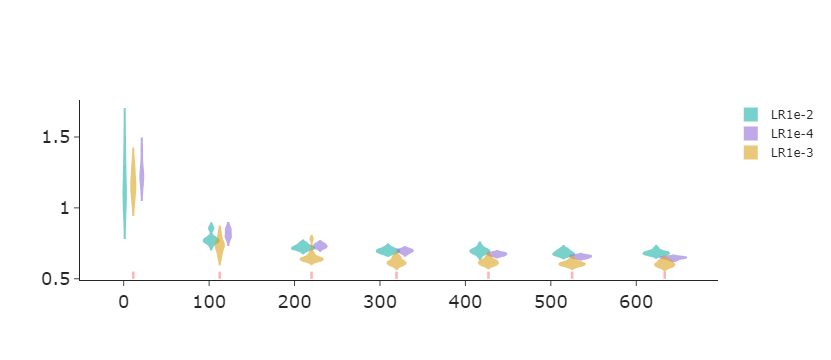

In [61]:
# fig = px.violin(bi_df_long[bi_df_long.variable != 'bi'], x="epoch", y="value", color="tag",
#                 title="Segmentation Agreement with Human Subjects")
fig = go.Figure()
tag_names = ['LR1e-2', 'LR1e-4', 'LR1e-3']
shifts = [-10, 10, 0]

# for i, tags in enumerate([update_tags_3m15 + update_tags_2m15, 
#                           update_tags_305 + update_tags_205]):
# for i, tags in enumerate([update_tags_3m15 + update_tags_305, 
#                           update_tags_306 + update_tags_3m26]):
for i, tags in enumerate([update_tags_2m15 + update_tags_205,
                          update_tags_4m24 + update_tags_4m15,
                          update_tags_3m15 + update_tags_305 + update_tags_3305_anneal]):
    df = n_rnns[(n_rnns.tag.isin(tags)) & (n_rnns.epoch.isin(range(1, 62, 10)))]
    fig.add_trace(
        go.Violin(x=df.training_time+shifts[i], y=df[f'mean_pe'], name=f"{tag_names[i]}", points=False,
                  fillcolor=colors[i], line_color=colors[i], opacity=0.6,
                  width=30, scalemode='width')
    )
    

fig.update_layout(layout)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis)
fig.update_layout(#title=dict(text="Purity of SEM Action Categorization"),
                 showlegend=True)
# fig.update_xaxes(title_text="Amount of Training (minutes)")
# fig.update_yaxes(title_text=f"Prediction Error")
# fig.add_annotation(dict(font=dict(color='black',size=17),
#                                         x=.3,
#                                         y=.9,
#                                         showarrow=False,
#                                         text="Each violin groups over<br>Concentration=[1e-1, 1e0]<br>LR=[1e-2, 1e-3, 1e-4]",
#                                         textangle=0,
#                                         xanchor='left',
#                                         xref="paper",
#                                         yref="paper"))
fig.update_layout(shapes=[{'type': 'line','y0':0.5,'y1': 0.55,'x0': t, 
                           'x1': t,
                           'xref':'x1','yref':'y1',
                           'line': {'color': 'red','width': 2.5}} 
                          for t in df.training_time.unique()],
                 width=800)
fig.show()

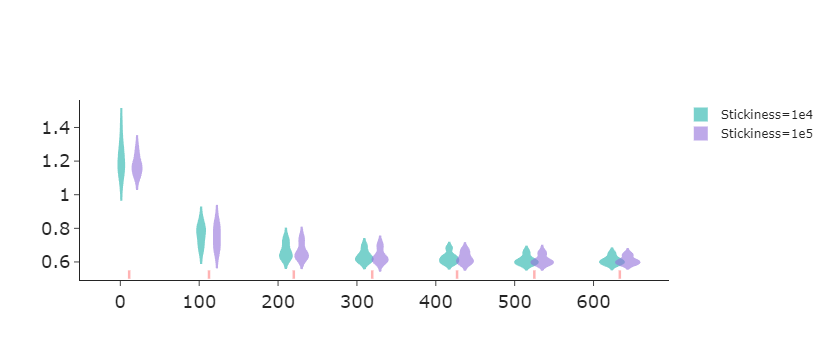

In [65]:
# fig = px.violin(bi_df_long[bi_df_long.variable != 'bi'], x="epoch", y="value", color="tag",
#                 title="Segmentation Agreement with Human Subjects")
fig = go.Figure()
tag_names = ['Stickiness=1e4', 'Stickiness=1e5']
shifts = [-10, 10, 0]

# update_tags_3m15 + update_tags_305 + update_tags_304 + update_tags_3m14 + \
#                 update_tags_306 + update_tags_307 + update_tags_316 + update_tags_317 + \
#                 update_tags_3m26 + update_tags_3m24 + update_tags_3m16 + update_tags_3m17 + \
#                 update_tags_205 + update_tags_2m15 + update_tags_4m15 + update_tags_4m24 + \
for i, tags in enumerate([update_tags_3m15 + update_tags_4m15 + update_tags_3m24,
                          update_tags_4m24 + update_tags_3m24 + update_tags_3m14]):
    df = n_rnns[(n_rnns.tag.isin(tags)) & (n_rnns.epoch.isin(range(1, 62, 10)))]
    fig.add_trace(
        go.Violin(x=df.training_time+shifts[i], y=df[f'mean_pe'], name=f"{tag_names[i]}", points=False,
                  fillcolor=colors[i], line_color=colors[i], opacity=0.6,
                  width=30, scalemode='width')
    )
    

fig.update_layout(layout)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis)
fig.update_layout(#title=dict(text="Purity of SEM Action Categorization"),
                 showlegend=True)
# fig.update_xaxes(title_text="Amount of Training (minutes)")
# fig.update_yaxes(title_text=f"Prediction Error")
# fig.add_annotation(dict(font=dict(color='black',size=17),
#                                         x=.3,
#                                         y=.9,
#                                         showarrow=False,
#                                         text="Each violin groups over<br>Concentration=[1e-1, 1e0]<br>LR=[1e-2, 1e-3, 1e-4]",
#                                         textangle=0,
#                                         xanchor='left',
#                                         xref="paper",
#                                         yref="paper"))
fig.update_layout(shapes=[{'type': 'line','y0':0.5,'y1': 0.55,'x0': t, 
                           'x1': t,
                           'xref':'x1','yref':'y1',
                           'line': {'color': 'red','width': 2.5}} 
                          for t in df.training_time.unique()],
                 width=800)
fig.show()

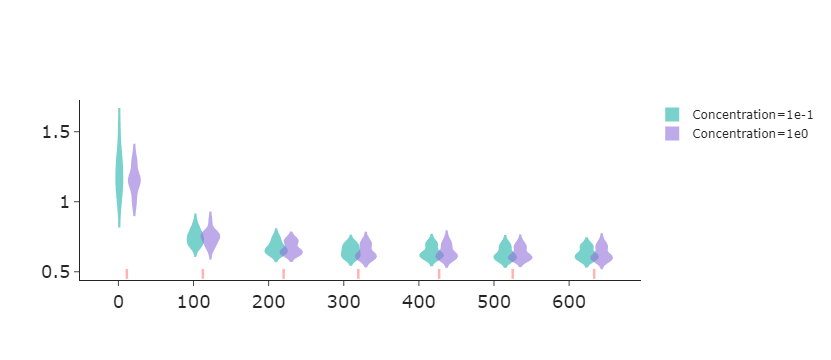

In [64]:
# fig = px.violin(bi_df_long[bi_df_long.variable != 'bi'], x="epoch", y="value", color="tag",
#                 title="Segmentation Agreement with Human Subjects")
fig = go.Figure()
tag_names = ['Concentration=1e-1', 'Concentration=1e0']
shifts = [-10, 10, 0]

# update_tags_3m15 + update_tags_305 + update_tags_304 + update_tags_3m14 + \
#                 update_tags_306 + update_tags_307 + update_tags_316 + update_tags_317 + \
#                 update_tags_3m26 + update_tags_3m24 + update_tags_3m16 + update_tags_3m17 + \
#                 update_tags_205 + update_tags_2m15 + update_tags_4m15 + update_tags_4m24 + \
for i, tags in enumerate([update_tags_3m15 + update_tags_3m16 + update_tags_2m15,
                          update_tags_305 + update_tags_306 + update_tags_205]):
    df = n_rnns[(n_rnns.tag.isin(tags)) & (n_rnns.epoch.isin(range(1, 62, 10)))]
    fig.add_trace(
        go.Violin(x=df.training_time+shifts[i], y=df[f'mean_pe'], name=f"{tag_names[i]}", points=False,
                  fillcolor=colors[i], line_color=colors[i], opacity=0.6,
                  width=30, scalemode='width')
    )
    

fig.update_layout(layout)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis)
fig.update_layout(#title=dict(text="Purity of SEM Action Categorization"),
                 showlegend=True)
# fig.update_xaxes(title_text="Amount of Training (minutes)")
# fig.update_yaxes(title_text=f"Prediction Error")
# fig.add_annotation(dict(font=dict(color='black',size=17),
#                                         x=.3,
#                                         y=.9,
#                                         showarrow=False,
#                                         text="Each violin groups over<br>Concentration=[1e-1, 1e0]<br>LR=[1e-2, 1e-3, 1e-4]",
#                                         textangle=0,
#                                         xanchor='left',
#                                         xref="paper",
#                                         yref="paper"))
fig.update_layout(shapes=[{'type': 'line','y0':0.45,'y1': 0.52,'x0': t, 
                           'x1': t,
                           'xref':'x1','yref':'y1',
                           'line': {'color': 'red','width': 2.5}} 
                          for t in df.training_time.unique()],
                 width=800)
fig.show()

## Schema Activations

In [215]:
seed = 3
names = ['SEM-1.0', 'SEM-1.1-add_generic', 'SEM-1.2-sUP', 'SEM-1.3-generic_sUP', 'SEM-2.0', 'SEM-1.4-add_previous']
# names = ['SEM-1.0', 'SEM-1.1-add_generic', 'SEM-1.2-sUP', 'SEM-1.3-generic_sUP', 'SEM-1.4-add_previous', 'SEM-2.0']
tags = [update_tags_pristine_3m15[seed], update_tags_w_generic_3m15[seed], \
        update_tags_wo_kappa_3m15[seed], update_tags_w_generic_wo_kappa_3m15[seed], \
        update_tags_3m15[seed+1], update_tags_wo_filler_3m15[seed]]
# tags = [update_tags_pristine_3m15[seed], update_tags_w_generic_3m15[seed], \
#         update_tags_wo_kappa_3m15[seed], update_tags_w_generic_wo_kappa_3m15[seed], \
#         update_tags_wo_filler_3m15[seed], update_tags_3m15[seed+1]]
list(zip(names, tags))

[('SEM-1.0', 'july_12_pristine_1040_1E-03_1E-01_1E+05'),
 ('SEM-1.1-add_generic', 'july_12_w_generic_1040_1E-03_1E-01_1E+05'),
 ('SEM-1.2-sUP', 'july_12_w_kappa_1040_1E-03_1E-01_1E+05'),
 ('SEM-1.3-generic_sUP', 'july_17_wo_kappa_w_generic_1040_1E-03_1E-01_1E+05'),
 ('SEM-2.0', 'june_28_1050_update_event_models'),
 ('SEM-1.4-add_previous', 'july_12_wo_filler_1040_1E-03_1E-01_1E+05')]

In [216]:
df = pd.DataFrame()
for n, t in zip(names, tags):
    readout_dataframes = pkl.load(open(f'output/run_sem/{t}/{valid_runs[10]}_kinect_trim{t}_diagnostic_41.pkl', 'rb'))
    train = pd.DataFrame({'c': readout_dataframes['c']})
    train = train[train.c > 0]
    train['schema'] = train.index
    val = pd.DataFrame({'c_eval': readout_dataframes['c_eval']})
    # val = val[val.c_eval > 0]
    val['schema'] = val.index
    activation = train.merge(val[['schema', 'c_eval']], on = 'schema', how = 'left')
    activation['tag'] = n
    # activation['schema'] = activation.index
    df = pd.concat([df, activation])
df.head(5)

,c,schema,c_eval,tag
0,22374.0,0,21394.0,SEM-1.0
1,1018.0,1,69.0,SEM-1.0
2,2.0,2,483.0,SEM-1.0
3,6.0,3,1656.0,SEM-1.0
4,12110.0,4,50684.0,SEM-1.0


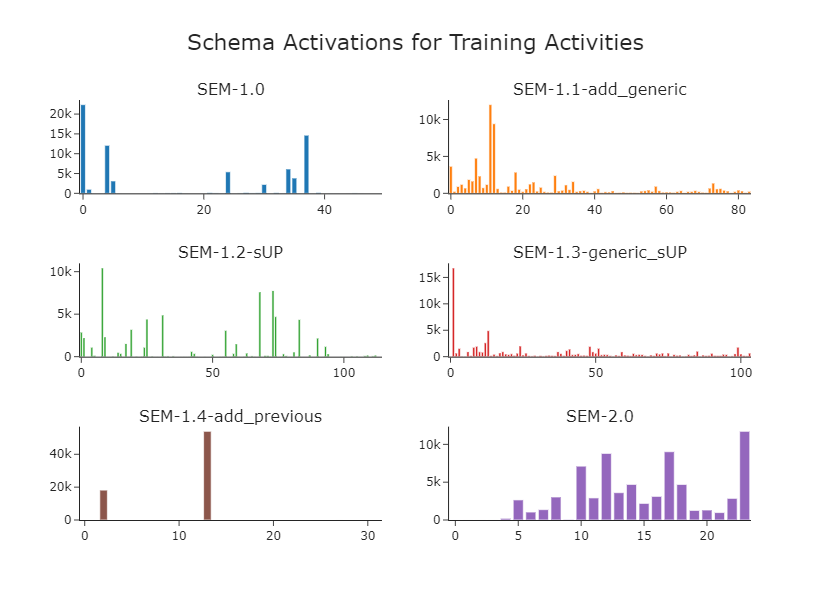

In [219]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=3, cols=2, 
                    subplot_titles=['SEM-1.0', 'SEM-1.1-add_generic', 'SEM-1.2-sUP', 'SEM-1.3-generic_sUP', 'SEM-1.4-add_previous', 'SEM-2.0']
                   )
for i, n in enumerate(names):
    df_select = df[df.tag == n]
    fig.add_trace(
    go.Bar(x=df_select.schema, y=df_select.c, name=f'{n}',
                 # xbins=go.histogram.XBins(size=1, start=0, end=len(activation)+2)
            ),
        row=(i//2 + 1), col=(i%2+1) if i < 4 else ((i+1)%2+1)
    )
# fig.update_traces(marker_color='brown', selector=dict(name="SEM-1.4-add_previous"))
fig.update_layout(layout, showlegend=False, 
                  title_text="Schema Activations for Training Activities", 
                  width=900, height=600)

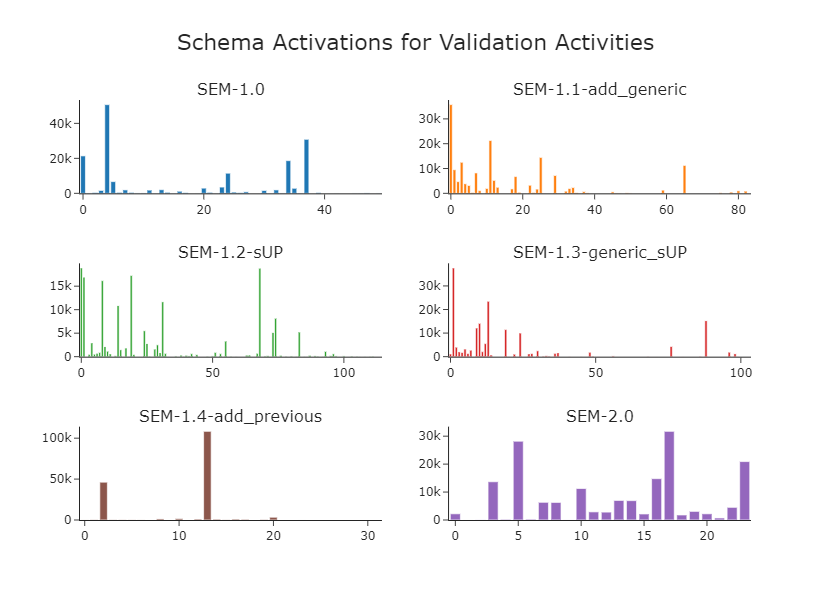

In [220]:
fig = make_subplots(rows=3, cols=2, 
                    subplot_titles=['SEM-1.0', 'SEM-1.1-add_generic', 'SEM-1.2-sUP', 'SEM-1.3-generic_sUP', 'SEM-1.4-add_previous', 'SEM-2.0']
                   )
for i, n in enumerate(names):
    df_select = df[df.tag == n]
    fig.add_trace(
    go.Bar(x=df_select.schema, y=df_select.c_eval,
                 # xbins=go.histogram.XBins(size=1, start=0, end=len(activation)+2)
            ),
        row=(i//2 + 1), col=(i%2+1) if i < 4 else ((i+1)%2+1)
    )
fig.update_layout(layout, showlegend=False, 
                  title_text="Schema Activations for Validation Activities",
                  width=900, height=600)

## Entropy

In [82]:
names = ['SEM-1.0', 'SEM-1.1-add_generic', 'SEM-1.2-sUP', 'SEM-1.3-generic_sUP', 'SEM-2.0', 'SEM-1.4-add_previous']
group_tags = [update_tags_pristine_3m15[:4], update_tags_w_generic_3m15[:4], \
        update_tags_wo_kappa_3m15[:4], update_tags_w_generic_wo_kappa_3m15[:4], \
        update_tags_3m15[:5], update_tags_wo_filler_3m15[:4]]
# list(zip(names, group_tags))

In [83]:
df = pd.DataFrame()
for n, tags in zip(names, group_tags):
    for t in tags:
        try:
            readout_dataframes = pkl.load(open(f'output/run_sem/{t}/{valid_runs[10]}_kinect_trim{t}_diagnostic_61.pkl', 'rb'))
            train = pd.DataFrame({'c': readout_dataframes['c']})
            train = train[train.c > 0]
            train['schema'] = train.index
            val = pd.DataFrame({'c_eval': readout_dataframes['c_eval']})
            # val = val[val.c_eval > 0]
            val['schema'] = val.index
            activation = train.merge(val[['schema', 'c_eval']], on = 'schema', how = 'left')
            activation['version'] = n
            activation['tag'] = t
            # activation['schema'] = activation.index
            df = pd.concat([df, activation])
        except:
            continue
df.head(5)

,c,schema,c_eval,version,tag
0,2.0,0,817.0,SEM-1.0,july_12_pristine_1010_1E-03_1E-01_1E+05
1,5893.0,1,16097.0,SEM-1.0,july_12_pristine_1010_1E-03_1E-01_1E+05
2,20.0,2,0.0,SEM-1.0,july_12_pristine_1010_1E-03_1E-01_1E+05
3,3.0,3,694.0,SEM-1.0,july_12_pristine_1010_1E-03_1E-01_1E+05
4,39.0,4,92.0,SEM-1.0,july_12_pristine_1010_1E-03_1E-01_1E+05


In [84]:
import scipy.stats as stats
def raw_entropy(c):
    return round(stats.entropy(c), 2)
def norm_entropy(c):
    return round(stats.entropy(c) / np.log((c > 0).sum()), 2)

In [85]:
df_norm = df.groupby(['version', 'tag'])[['c', 'c_eval']].agg({"c": norm_entropy, 
                                                             "c_eval": norm_entropy})
df_norm

c  \
version              tag                                                       
SEM-1.0              july_12_pristine_1010_1E-03_1E-01_1E+05            0.51   
                     july_12_pristine_1020_1E-03_1E-01_1E+05            0.58   
                     july_12_pristine_1030_1E-03_1E-01_1E+05            0.65   
                     july_12_pristine_1040_1E-03_1E-01_1E+05            0.52   
SEM-1.1-add_generic  july_12_w_generic_1010_1E-03_1E-01_1E+05           0.69   
                     july_12_w_generic_1020_1E-03_1E-01_1E+05           0.66   
                     july_12_w_generic_1030_1E-03_1E-01_1E+05           0.74   
                     july_12_w_generic_1040_1E-03_1E-01_1E+05           0.79   
SEM-1.2-sUP          july_12_w_kappa_1010_1E-03_1E-01_1E+05             0.67   
                     july_12_w_kappa_1020_1E-03_1E-01_1E+05             0.68   
                     july_12_w_kappa_1030_1E-03_1E-01_1E+05             0.65   
                     july_12_w_kappa_1040_1E-03_1E-01_1E+05             0.62   
SEM-1.3-generic_sUP  july_17_wo_kappa_w_generic_1010_1E-03_1E-01_1E+05  0.88   
                     july_17_wo_kappa_w_generic_1020_1E-03_1E-01_1E+05  0.91   
                     july_17_wo_kappa_w_generic_1030_1E-03_1E-01_1E+05  0.91   
                     july_17_wo_kappa_w_generic_1040_1E-03_1E-01_1E+05  0.81   
SEM-1.4-add_previous july_12_wo_filler_1010_1E-03_1E-01_1E+05           0.43   
                     july_12_wo_filler_1020_1E-03_1E-01_1E+05           0.39   
                     july_12_wo_filler_1030_1E-03_1E-01_1E+05           0.26   
                     july_12_wo_filler_1040_1E-03_1E-01_1E+05           0.16   
SEM-2.0              june_28_1010_update_event_models                   0.81   
                     june_28_1020_update_event_models                   0.89   
                     june_28_1030_update_event_models                   0.83   
                     june_28_1050_update_event_models                   0.81   

                                                                        c_eval  
version              tag                                                        
SEM-1.0              july_12_pristine_1010_1E-03_1E-01_1E+05              0.64  
                     july_12_pristine_1020_1E-03_1E-01_1E+05              0.65  
                     july_12_pristine_1030_1E-03_1E-01_1E+05              0.72  
                     july_12_pristine_1040_1E-03_1E-01_1E+05              0.61  
SEM-1.1-add_generic  july_12_w_generic_1010_1E-03_1E-01_1E+05             0.61  
                     july_12_w_generic_1020_1E-03_1E-01_1E+05             0.64  
                     july_12_w_generic_1030_1E-03_1E-01_1E+05             0.66  
                     july_12_w_generic_1040_1E-03_1E-01_1E+05             0.74  
SEM-1.2-sUP          july_12_w_kappa_1010_1E-03_1E-01_1E+05               0.72  
                     july_12_w_kappa_1020_1E-03_1E-01_1E+05               0.75  
                     july_12_w_kappa_1030_1E-03_1E-01_1E+05               0.73  
                     july_12_w_kappa_1040_1E-03_1E-01_1E+05               0.69  
SEM-1.3-generic_sUP  july_17_wo_kappa_w_generic_1010_1E-03_1E-01_1E+05    0.73  
                     july_17_wo_kappa_w_generic_1020_1E-03_1E-01_1E+05    0.70  
                     july_17_wo_kappa_w_generic_1030_1E-03_1E-01_1E+05    0.71  
                     july_17_wo_kappa_w_generic_1040_1E-03_1E-01_1E+05    0.69  
SEM-1.4-add_previous july_12_wo_filler_1010_1E-03_1E-01_1E+05             0.56  
                     july_12_wo_filler_1020_1E-03_1E-01_1E+05             0.62  
                     july_12_wo_filler_1030_1E-03_1E-01_1E+05             0.45  
                     july_12_wo_filler_1040_1E-03_1E-01_1E+05             0.29  
SEM-2.0              june_28_1010_update_event_models                     0.89  
                     june_28_1020_update_event_models                     0.87  
                     june_28_1030_update_event_mod

In [86]:
df_norm = df_norm.loc[names, :, :]

In [87]:
df_norm = df_norm.reset_index()
df_norm = pd.melt(df_norm, id_vars = ["version", "tag"], value_vars=['c', 'c_eval'])
df_norm.head(5)

,version,tag,variable,value
0,SEM-1.0,july_12_pristine_1010_1E-03_1E-01_1E+05,c,0.51
1,SEM-1.0,july_12_pristine_1020_1E-03_1E-01_1E+05,c,0.58
2,SEM-1.0,july_12_pristine_1030_1E-03_1E-01_1E+05,c,0.65
3,SEM-1.0,july_12_pristine_1040_1E-03_1E-01_1E+05,c,0.52
4,SEM-1.1-add_generic,july_12_w_generic_1010_1E-03_1E-01_1E+05,c,0.69


In [88]:
df_norm['variable'] = df_norm['variable'].apply(lambda x: "Training Activities" if x == "c" else "Validation Activities")

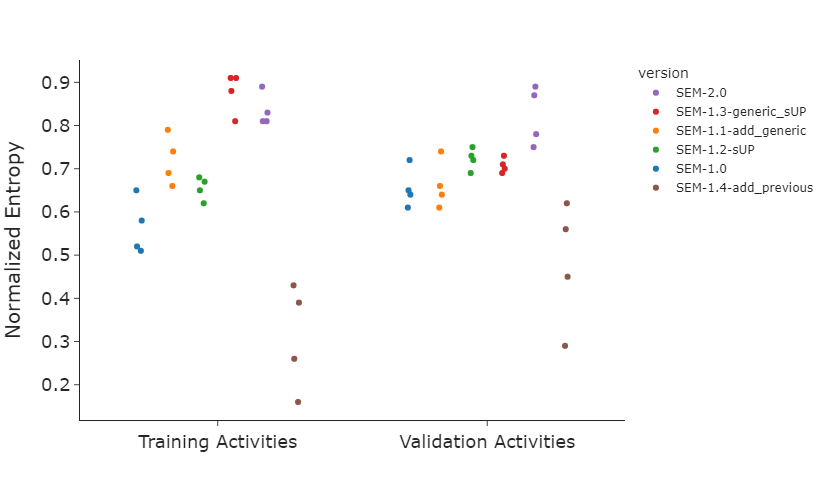

In [89]:
fig = px.strip(df_norm, x='variable', y='value', color='version', hover_name='tag', 
               # category_orders={'version': ['SEM-2.0', 'SEM-1.3-generic-sUP', 'SEM-1.1-add_generic',
                                            # 'SEM-1.0', 'SEM-1.4-add_previous']}
               category_orders={'version': names}
              )
fig.update_layout(layout)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis)
fig.update_layout(width=800, height=500)
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='Normalized Entropy')
fig.update_traces(
                  # row=1, col=1,
                  # fillcolor=colors[1], line_color=colors[1], 
                  legendrank=1,
                  # width=100, points=False, scalemode="width", 
                  selector=dict(name="SEM-2.0")
)
fig.update_traces(legendrank=2, selector=dict(name="SEM-1.3-generic_sUP"))
fig.update_traces(legendrank=3, selector=dict(name="SEM-1.1-add_generic"))
fig.update_traces(legendrank=4, selector=dict(name="SEM-1.2-sUP"))
fig.update_traces(legendrank=6, selector=dict(name="SEM-1.0"))
fig.update_traces(legendrank=7, selector=dict(name="SEM-1.4-add_previous"))

fig.show()
# fig.update_layout(title_text='Schema Activation after watching 11 activities')

## Prediction Error (Modifications)

In [68]:
n_rnns

,epoch,tag,mean_pe,training_time
0,1.0,april_04_grid_lr1E-03_alfa1E-01_lmda1E+05,1.092133,11.209184
1,1.0,april_04_grid_lr1E-03_alfa1E-01_lmda1E+06,1.103410,11.209184
2,1.0,april_04_grid_lr1E-03_alfa1E-02_lmda1E+05,1.098921,11.209184
3,1.0,april_04_grid_lr1E-03_alfa1E-02_lmda1E+06,0.954907,11.209184
4,1.0,aug_05_n15_1010_1E-03_1E-01_1E+07,1.348895,11.209184
...,...,...,...,...
7328,176.0,feb_11_cleaned_segmentation_grid_lr1E-03_alfa1...,0.632292,NaN
7329,176.0,feb_11_cleaned_segmentation_grid_lr1E-03_alfa1...,0.627612,NaN
7330,176.0,feb_11_cleaned_segmentation_grid_lr1E-03_alfa1...,0.635430,NaN
7331,176.0,feb_11_cleaned_segmentation_grid_lr1E-03_alfa1...,0.646874,NaN


In [72]:
names = ['SEM-1.0', 'SEM-1.1-add_generic', 'SEM-1.2-sUP', 'SEM-1.3-generic_sUP', 'SEM-2.0', 'SEM-1.4-add_previous']
group_tags = [update_tags_pristine_3m15[:4], update_tags_w_generic_3m15[:4], \
        update_tags_wo_kappa_3m15[:4], update_tags_w_generic_wo_kappa_3m15[:4], \
        update_tags_3m15[:5], update_tags_wo_filler_3m15[:4]]
# list(zip(names, group_tags))
df_pe = deepcopy(n_rnns)
df_pe['version'] = ''
for n, tags in zip(names, group_tags):
    df_pe.loc[df_pe.tag.isin(tags), 'version'] = n

In [74]:
df_pe[df_pe.version == 'SEM-1.0'].head()

,epoch,tag,mean_pe,training_time,version
219,1.0,july_12_pristine_1010_1E-03_1E-01_1E+05,1.213349,11.209184,SEM-1.0
220,1.0,july_12_pristine_1020_1E-03_1E-01_1E+05,1.223623,11.209184,SEM-1.0
221,1.0,july_12_pristine_1030_1E-03_1E-01_1E+05,1.150063,11.209184,SEM-1.0
222,1.0,july_12_pristine_1040_1E-03_1E-01_1E+05,1.166593,11.209184,SEM-1.0
1387,11.0,july_12_pristine_1010_1E-03_1E-01_1E+05,0.855240,112.434764,SEM-1.0


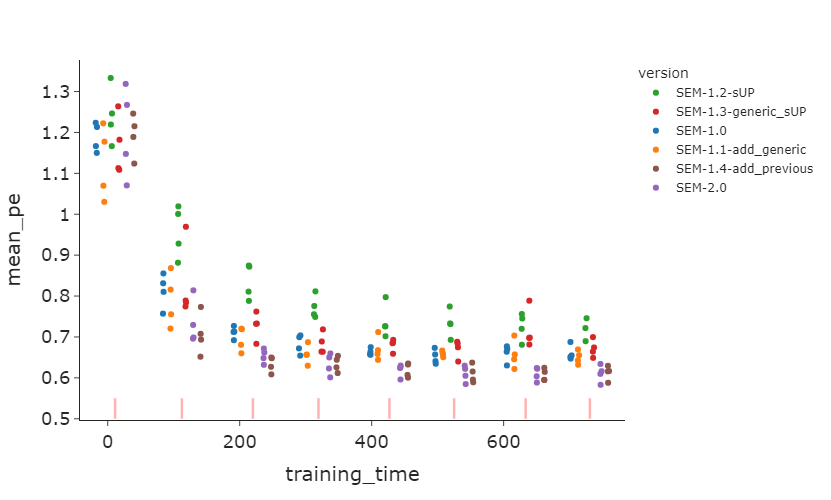

In [90]:
fig = px.strip(df_pe[df_pe.version.isin(names)], x='training_time', y='mean_pe', color='version', hover_name='tag', 
               # category_orders={'version': ['SEM-2.0', 'SEM-1.3-generic-sUP', 'SEM-1.1-add_generic',
                                            # 'SEM-1.0', 'SEM-1.4-add_previous']}
               category_orders={'version': names}
              )
fig.update_layout(layout)
fig.update_xaxes(x_axis)
fig.update_yaxes(y_axis)
fig.update_layout(width=800, height=500)

fig.update_traces(legendrank=7, selector=dict(name="SEM-2.0"))
fig.update_traces(legendrank=2, selector=dict(name="SEM-1.3-generic_sUP"))
fig.update_traces(legendrank=4, selector=dict(name="SEM-1.1-add_generic"))
fig.update_traces(legendrank=1, selector=dict(name="SEM-1.2-sUP"))
fig.update_traces(legendrank=3, selector=dict(name="SEM-1.0"))
fig.update_traces(legendrank=5, selector=dict(name="SEM-1.4-add_previous"))
fig.update_layout(shapes=[{'type': 'line','y0':0.5,'y1': 0.55,'x0': t, 
                           'x1': t,
                           'xref':'x1','yref':'y1',
                           'line': {'color': 'red','width': 2.5}} 
                          for t in df_pe[df_pe.version.isin(names)].training_time.unique()])
fig.show()